# Multiple-Network Representation Learning

## Data Generation

Say you're a brain researcher, and you have a bunch of scans of brains - some are scans of people, and some are scans of aliens. You have some code that estimates networks from your scans, so you turn all your scans into networks. The nodes represent the brain regions which are common to both humans and aliens (isn't evolution amazing?), and the edges represent communication between these brain regions. You want to know if the human and alien networks share a common grouping of regions (your research topic is titled, "Do Alien Brains Have The Same Hemispheres That We Do?"). What do you do? How do you even deal with situations in which you have a lot of networks whose nodes all represent the same objects, but whose edges might come from totally different distributions?

Well, if your goal is to find the shared grouping of regions between the human and alien networks, you could try embedding your networks and then seeing what those embeddings look like. This would serve the dual purpose of having less stuff to deal with and having some way to directly compare all of your networks in the same space. Finding an embedding is also simply useful in general, because embedding a network or group of networks opens the door to machine learning methods designed for tabular data.

For example, say you have four alien networks and four human networks. Since alien brain networks aren't currently very accessible, we'll just simulate our human and alien networks with Stochastic Block Models. The communities that we're trying to group all of the brain regions into are the two hemispheres of the brain. We'll design the human brains to have strong connections within hemispheres, and we'll design the alien brains to have strong connections between hemispheres -- but the same regions still correspond to the same hemispheres.

we'll use a relatively small number of nodes and fairly small block probabilities. You can see the specific parameters in the code below.

In [1]:
import warnings
import numpy as np
warnings.filterwarnings("ignore")
np.random.seed(42)
%load_ext autoreload

In [2]:
import numpy as np
from graspologic.simulations import sbm

# Generate networks from an SBM, given some parameters
def make_sbm(*probs, n=100, return_labels=False):
    pa, pb, pc, pd = probs
    P = np.array([[pa, pb], 
                  [pc, pd]])
    
    return sbm([n, n], P, return_labels=return_labels)

# make nine human networks
# and nine alien networks
p1, p2, p3 = .12, .06, .03
n = 100
labels = [0]*n + [1]*n
humans = [make_sbm(p1, p3, p3, p1, n=n) for i in range(4)]
aliens = [make_sbm(p3, p1, p1, p3, n=n) for i in range(4)]

The human and alien networks come from very different distributions. As you can see from the Stochastic Block Model structure below, the regions in the human and the alien brains can both be separated into two communities. These communities represent the two hemispheres of the brain (who knew aliens also have bilateralized brains!). Although both humans and aliens have the same regions belonging to their respective hemispheres, as we planned, the alien networks have a strange property: their brain regions have more connections with regions in the opposite hemisphere than the same one.

Text(0.5, 1.1, 'Different Sets of Brain Networks')

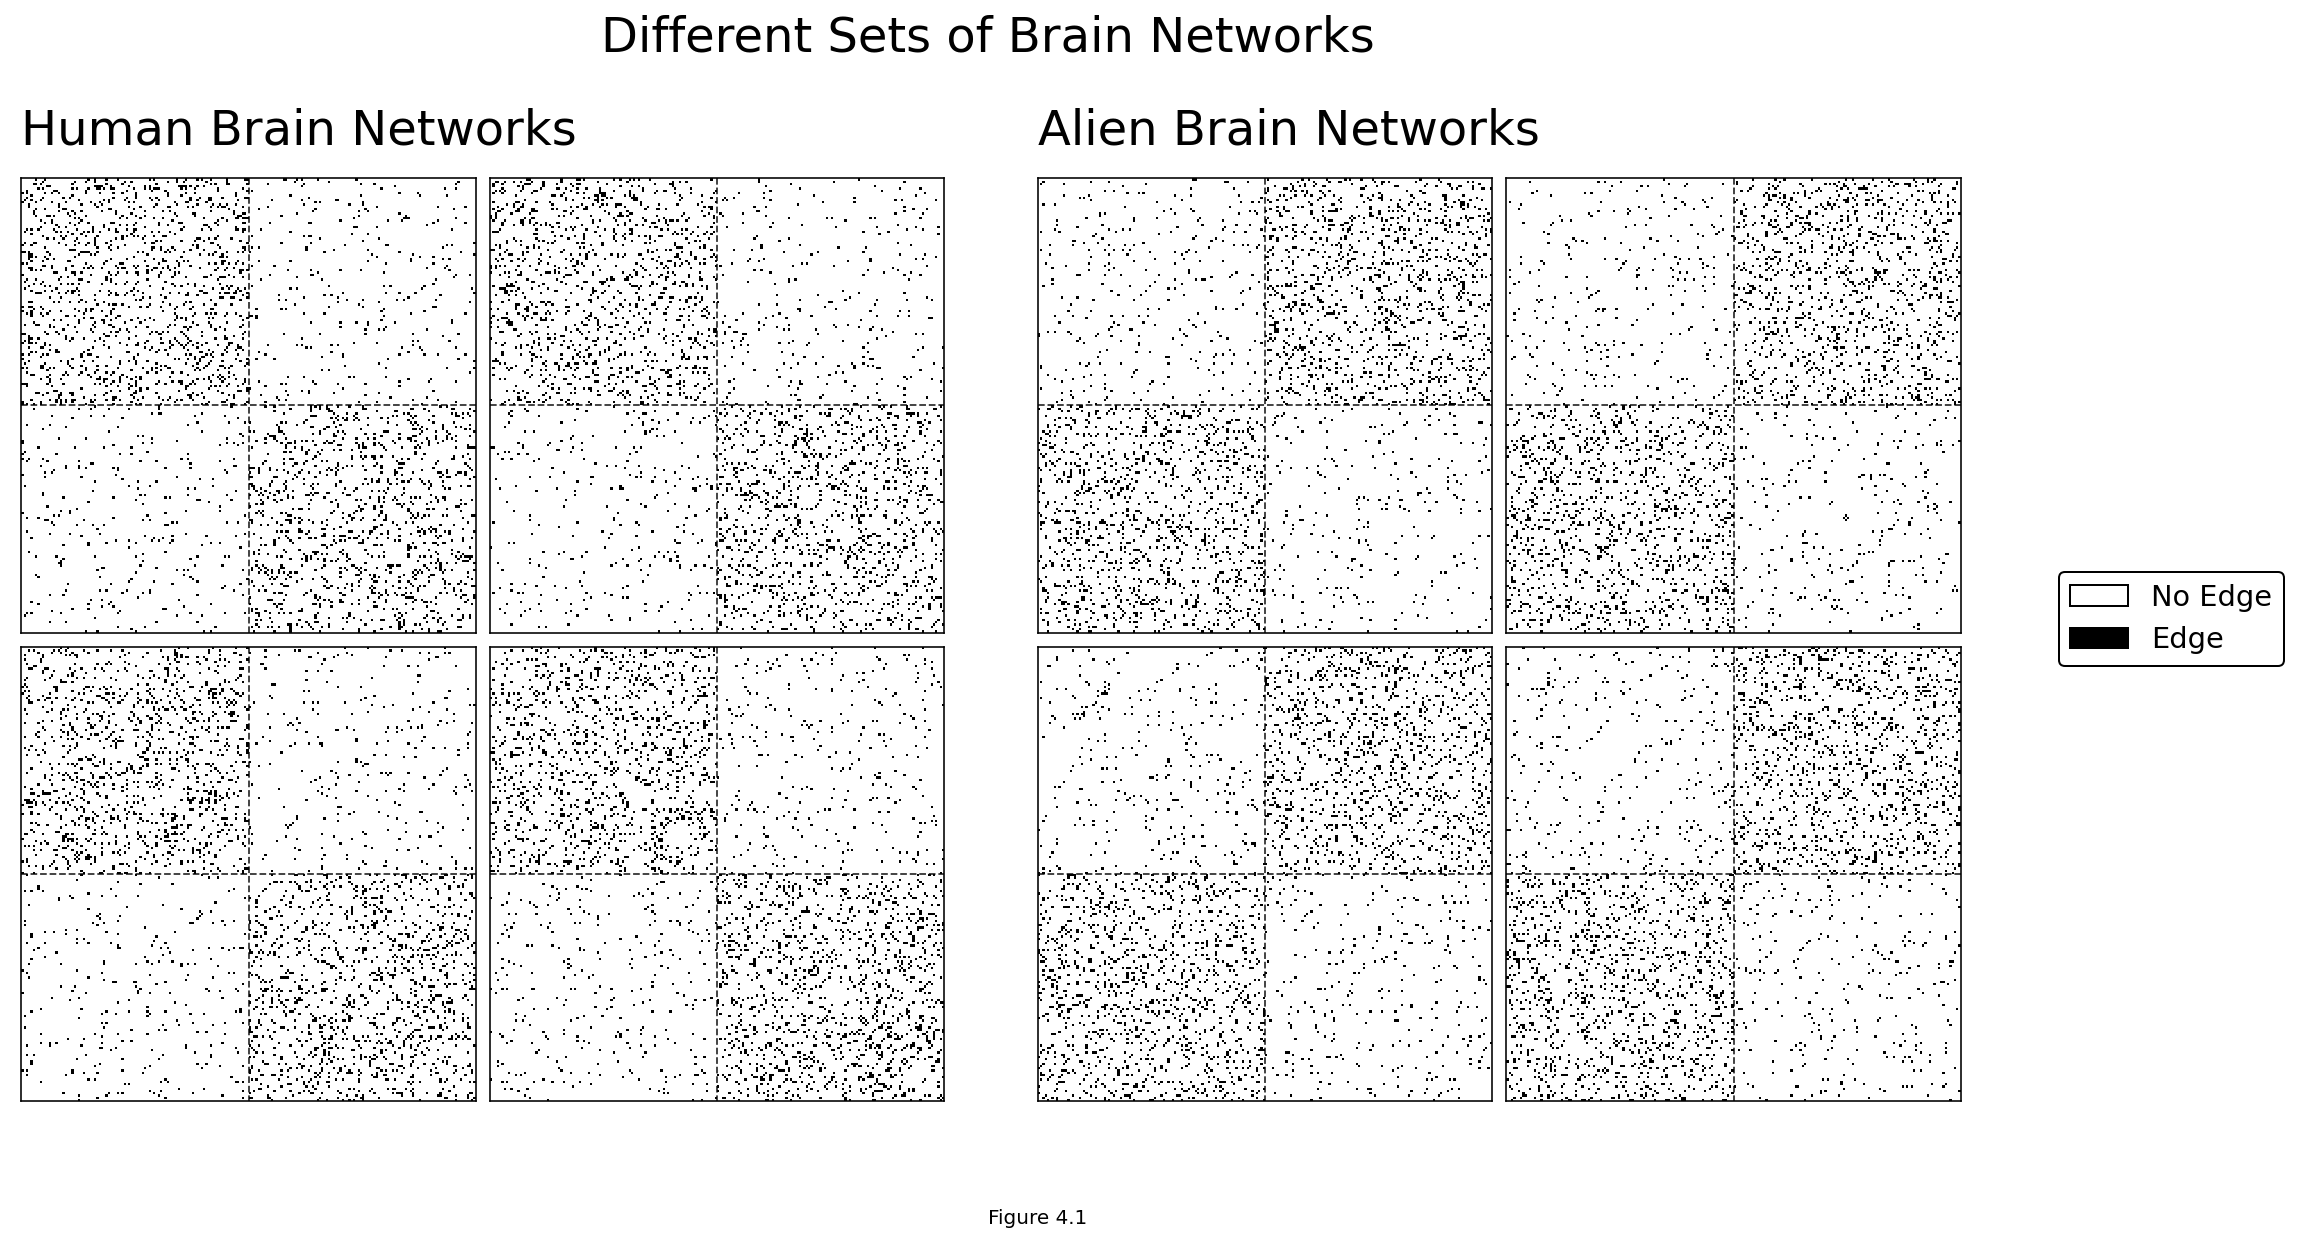

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
from graspologic.plot import adjplot, heatmap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from graphbook_code import lined_heatmap, add_legend

%config InlineBackend.figure_format = 'retina'



fig = plt.figure(figsize=(14,7))

grid1 = ImageGrid(fig, 121, (2, 2), axes_pad=.1, share_all=True)
grid2 = ImageGrid(fig, 122, (2, 2), axes_pad=.1, share_all=True)

for i, (axi, axj) in enumerate(zip(grid1, grid2)):
    hmn = lined_heatmap(humans[i], ax=axi, legend=False, outline=True)
    hma = lined_heatmap(aliens[i], ax=axj, legend=False, outline=True)
    

grid1.axes_all[0].set_title("Human Brain Networks", fontsize=24, y=1.05, loc="left")
grid2.axes_all[0].set_title("Alien Brain Networks", fontsize=24, y=1.05, loc="left")

add_legend(grid2.axes_all[2])

plt.tight_layout(w_pad=3)

plt.figtext(0.5, -.1, "Figure 4.1")
plt.suptitle("Different Sets of Brain Networks", fontsize=24, y=1.1)

## Simple Embedding Methods on Multiple Networks

Remember, our goal is to find community structure common to both humans and aliens, and in our case that community structure is the brain hemispheres. We're going to try to to embed our brain networks into some lower-dimensional space - that way, we can use standard clustering methods from machine learning to figure out which regions are grouped. Try to think about how you might find a lower-dimensional embedding where the location of each node's latent positions uses information from all of the networks.

### Averaging Separately

The first idea you might come up with is to average your networks together, and then embed the result of that averaging with Spectral Embedding. It turns out that this is actually the right idea in the very special case where all of your networks come from the same probability distribution. In our case, we'll try averaging our groups of networks separately: we'll treat the human networks as one group, and the alien networks as another group, and we'll average each independently. In the end, we'll have two separate embeddings.

In [4]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

# Compute the average adjacency matrix for 
# human brains and alien brains
human_mean_network = np.array(humans).mean(axis=0)
alien_mean_network = np.array(aliens).mean(axis=0)

# Embed both matrices
ase = ASE(n_components=2)
human_latents = ase.fit_transform(human_mean_network)
alien_latents = ase.fit_transform(alien_mean_network)

Below, you can see what happens when we embed the averaged human and alien networks separately. Like all of our embedding plots, each dot represents the latent positions for a particular node.

Text(0.5, 1.05, 'Averaged Embedded Networks')

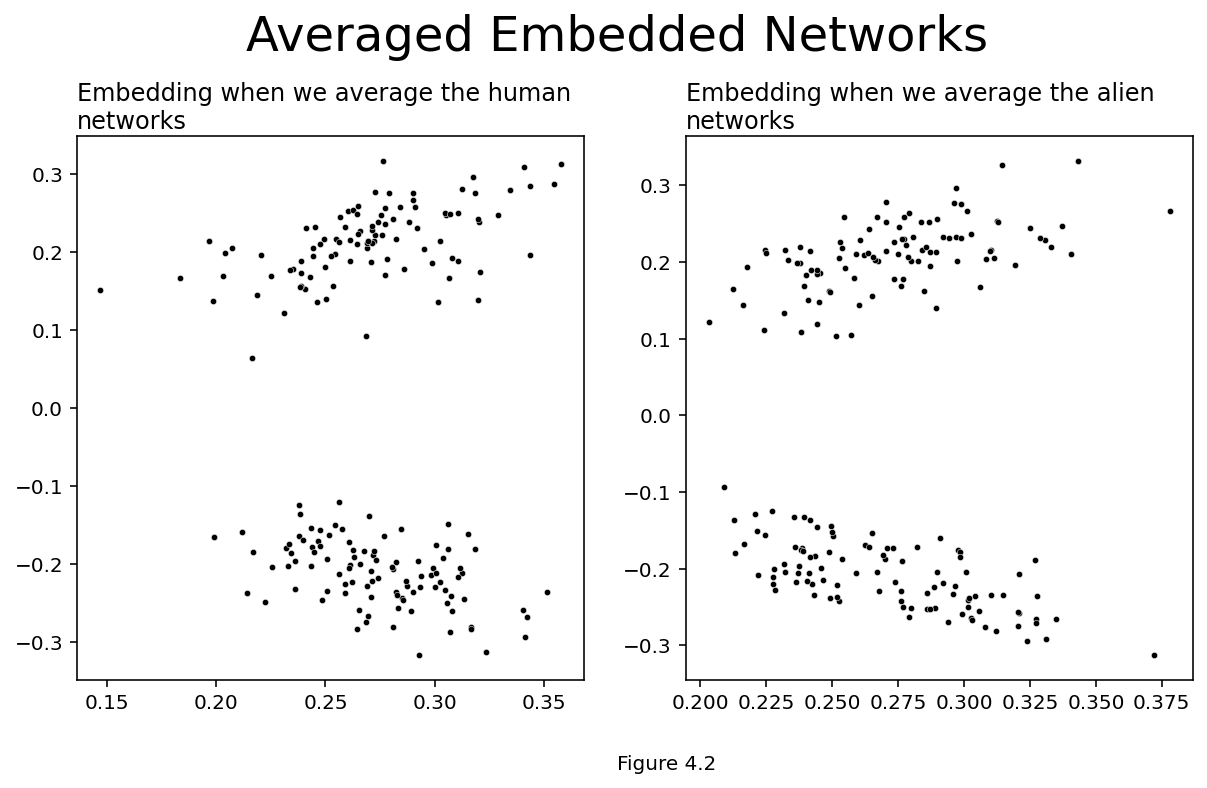

In [5]:
from graphbook_code import plot_latents
import seaborn as sns

# plot
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
plot_latents(human_latents, title="Embedding when we average the human \nnetworks", ax=axs[0]);
plot_latents(alien_latents, title="Embedding when we average the alien \nnetworks", ax=axs[1]);

plt.figtext(0.5, 0, "Figure 4.2")
plt.suptitle("Averaged Embedded Networks", fontsize=24, y=1.05)

Both of these embeddings have clear clustering: there are two communities of nodes in both the human and the alien networks. We can recover the labels for these communities fairly easily using our pick of unsupervised clustering method. We know that the latent positions in each community of an Adjacency Spectral Embedding are normally distributed under this simulation setting, and we have two communities. That means that the above embeddings are distributed according to a Gaussian Mixture. Here, "Gaussian" just means "normal", and a gaussian mixture just means that we have groups of normally distributed data clusters. As a result, it makes sense to cluster these data using scikit-learn's GaussianMixture implementation.

In [6]:
from sklearn.mixture import GaussianMixture as GMM

# Predict labels for the human and alien brains
human_labels = GMM(n_components=2).fit_predict(human_latents)
alien_labels = GMM(n_components=2).fit_predict(alien_latents)

You can see a plot that predicts our community structure below. Success! When we embed the human and the alien networks separately, averaging them clearly lets us cluster the brain regions by hemisphere. However, as you can see, the colors are flipped: the communities are in different places relative to each other. This is because the alien networks are drawn from a different distribution than the human networks. 

Text(0.5, 1.05, 'Clustering with GMM')

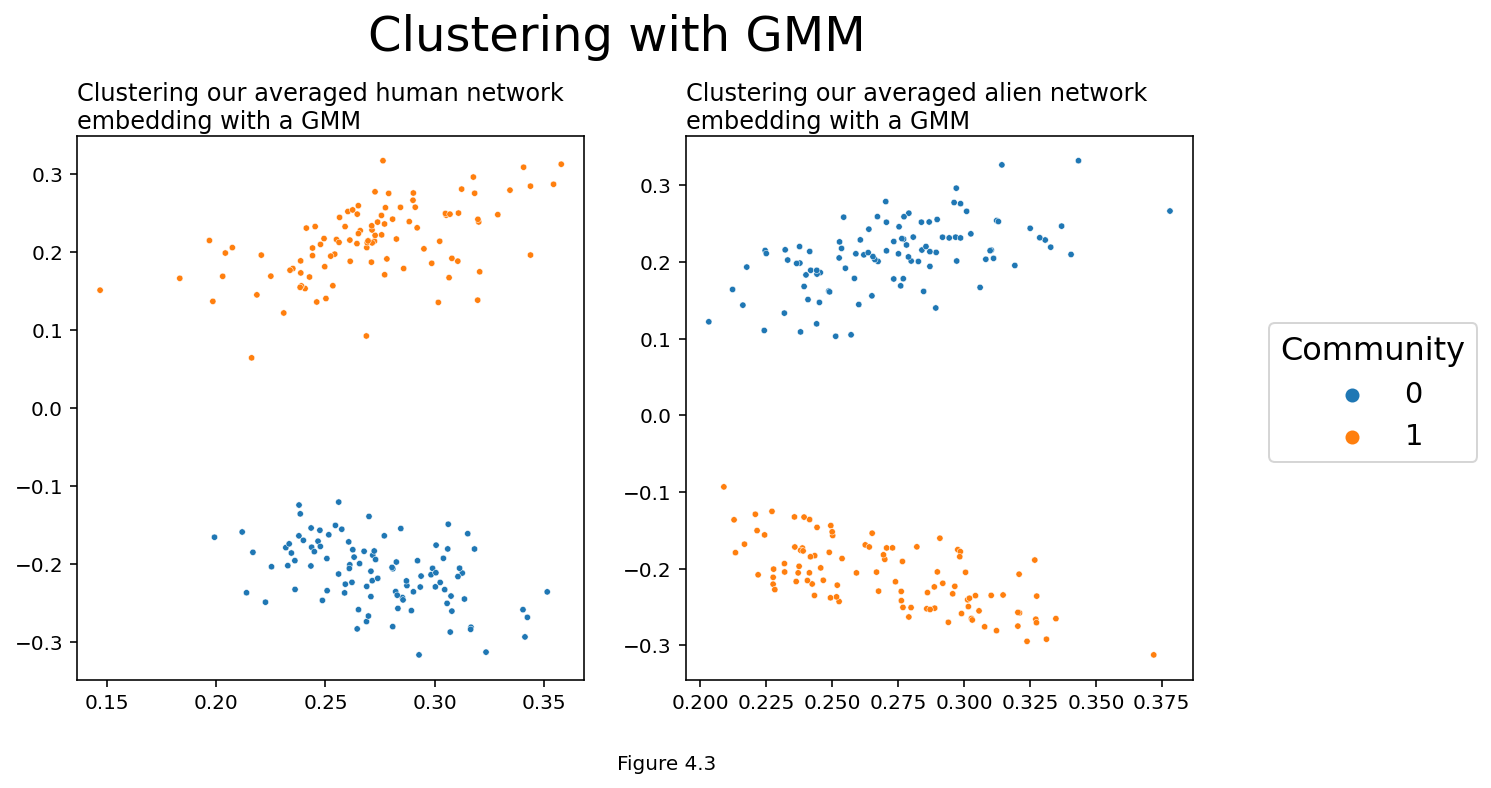

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

plot_latents(human_latents, title="Clustering our averaged human network \nembedding with a GMM", 
             labels=human_labels, ax=axs[0], legend=False)
plot_latents(alien_latents, title="Clustering our averaged alien network \nembedding with a GMM", 
             labels=alien_labels, ax=axs[1], legend=False)

plt.legend(loc=(1.15, .4), fontsize="x-large", title="Community",
           title_fontsize=16);

plt.figtext(0.5, 0, "Figure 4.3")
plt.suptitle("Clustering with GMM", fontsize=24, y=1.05)

### Averaging Together

But what if you wanted to embed *all* of the networks into the same space, both the human and the alien networks, so that there's only one plot? Let's try it. We'll take all of the networks and then average them together, and then do an Adjacency Spectral Embedding. This will result in a single plot, with each point representing a single brain region. Do you think we'll still find this nice community separation?

In [8]:
total_mean_matrix = np.array(humans + aliens).mean(axis=0)
all_latents = ase.fit_transform(total_mean_matrix)

Text(0.5, 0, 'Figure 4.4')

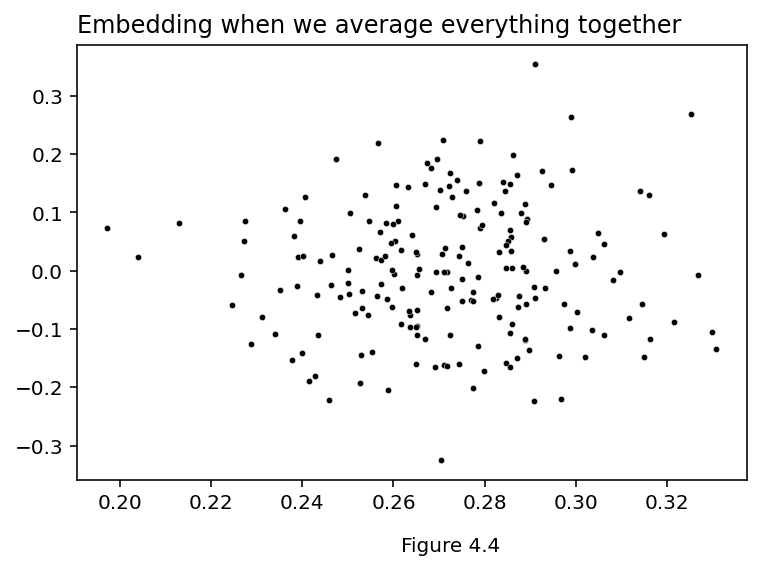

In [9]:
plot_latents(all_latents, title="Embedding when we average everything together");
plt.figtext(0.5, 0, "Figure 4.4")

Nope, bummer. Our community separation into discrete hemispheres is gone - the human networks and the alien networks cancelled each other out. As far as anybody can tell, our latent positions have just become meaningless noise, so we can't cluster and find communities like we did before.

#### Why Did Averaging Together Fail?

Why did this happen? Well, let's go back and compare one human brain network with one alien brain network.

Text(0.5, 0, 'Figure 4.5')

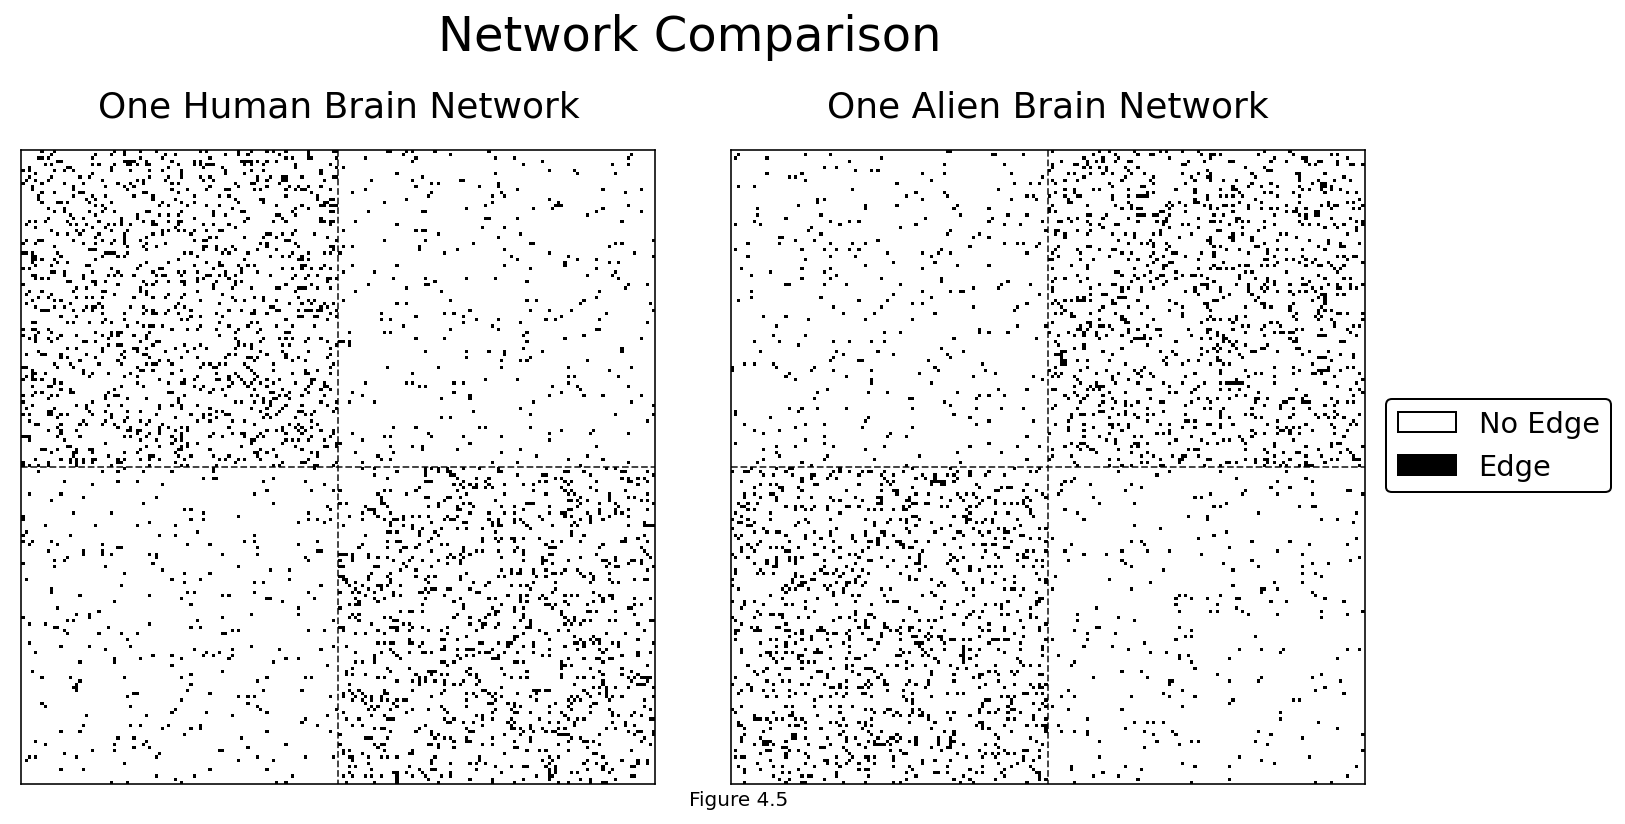

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
hmn = lined_heatmap(humans[0], ax=axs[0], legend=False, title="One Human Brain Network")
hma = lined_heatmap(aliens[0], ax=axs[1], legend=False, title="One Alien Brain Network")

add_legend(humans[0])
plt.tight_layout()

plt.suptitle("Network Comparison", fontsize=24, y=1.1)
plt.figtext(0.5, 0, "Figure 4.5")

The human network has more edges in the upper-left and lower-left quadrants of the heatmap. This implies that two regions in the same hemisphere are more likely to be connected for humans than two regions in opposite hemispheres.

The alien network tells a different story. For aliens, two regions in opposite hemispheres are more likely to be connected than two regions in the same hemisphere.

But what happens when you average these two adjacency matrices together?

In [11]:
combined = np.array([humans[0], aliens[0]])
averaged = np.mean(combined, axis=0)

Text(0.5, 0, 'Figure 4.7')

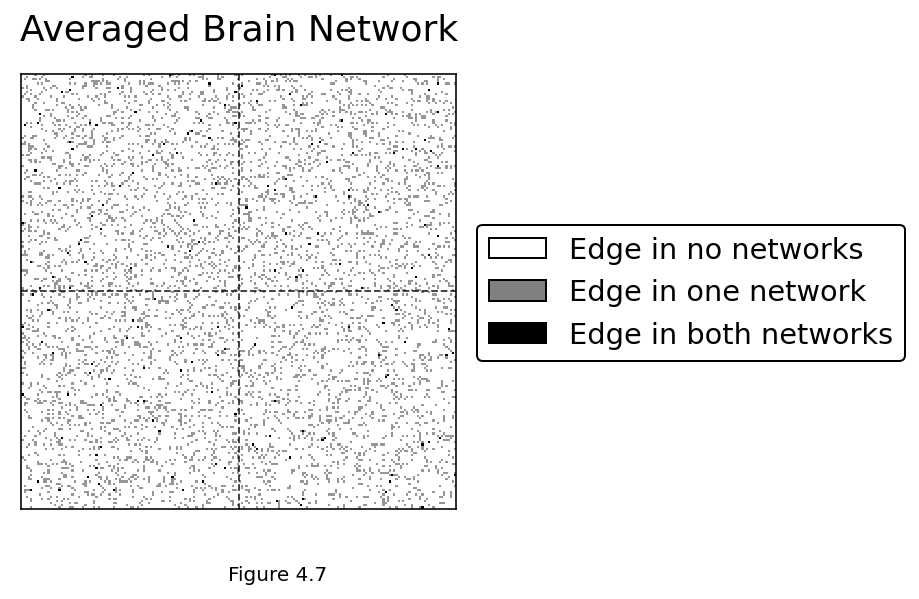

In [12]:
from graspologic.plot import heatmap

# plot
fig, ax = plt.subplots()
cmap = plt.get_cmap('Greys', 3)
hm = heatmap(averaged, title="Averaged Brain Network", cbar=False, cmap=cmap, center=None, ax=ax);
sns.despine(ax=hm, top=False, bottom=False, left=False, right=False)
hm.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
hm.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)

# # colorbar
add_legend(hm, legend_labels=["Edge in no networks", "Edge in one network", "Edge in both networks"],
           colors=["white", "grey", "black"], bbox_to_anchor=(1.3, .5))

plt.figtext(0.5, 0, "Figure 4.7")

By averaging, we've lost all of the community structure used to exist. That's why our big averaged embedding failed. 

We've just discovered that even though it's oten a great idea to simply average all of your networks together - for example, if they were drawn from the same distribution - it's often a horrible idea to average all of your networks if they might come from different distributions. This is a case of averaging networks which are "heterogeneous": Not only are your networks slightly different, but they're *should* to be different because their edge probabilities aren't the same. Sampling a lot of heterogenous networks and then averaging them, as you can see from our exploration above, can result in losing the community signal you might have had.

We'd like to find a way to compare these heterogeneous networks directly, so that we can embed all of our networks into the same space and still keep that nice community structure. Figuring out the best way to do this is a topic under active research, and the set of techniques and tools that have developed as a result are together called multiple-network representation learning.

## Different Types of Multiple-Network Representation Learning

Let's take a moment to explore some of the possible general approaches we could take in multiple-network representation learning. At some point we need to combine the many individual representations of our networks into one, and there are at least three possible places where we could do this: combining the networks together, combining the networks separately, and combining the embeddings. Each of these eventually results in a latent position representation for our networks. It's important to note that in all of these approaches, we're simply learning representations for our groups of networks. You can do whatever you want with these representations; in our case, we'll illustrate that we can use them to classify our nodes.

### Combining the Networks Together

With this approach, you'll start with a set of networks, and then you'll combine them all into a single network prior to doing anything else. You can then embed and classify this network directly. What we did before, averaging the human and alien networks, was an example of combining our networks -- we just averaged all of our adjacency matrices, and then we embedded the result.

Text(1.7, -0.2, 'Figure 4.7')

<Figure size 432x288 with 0 Axes>

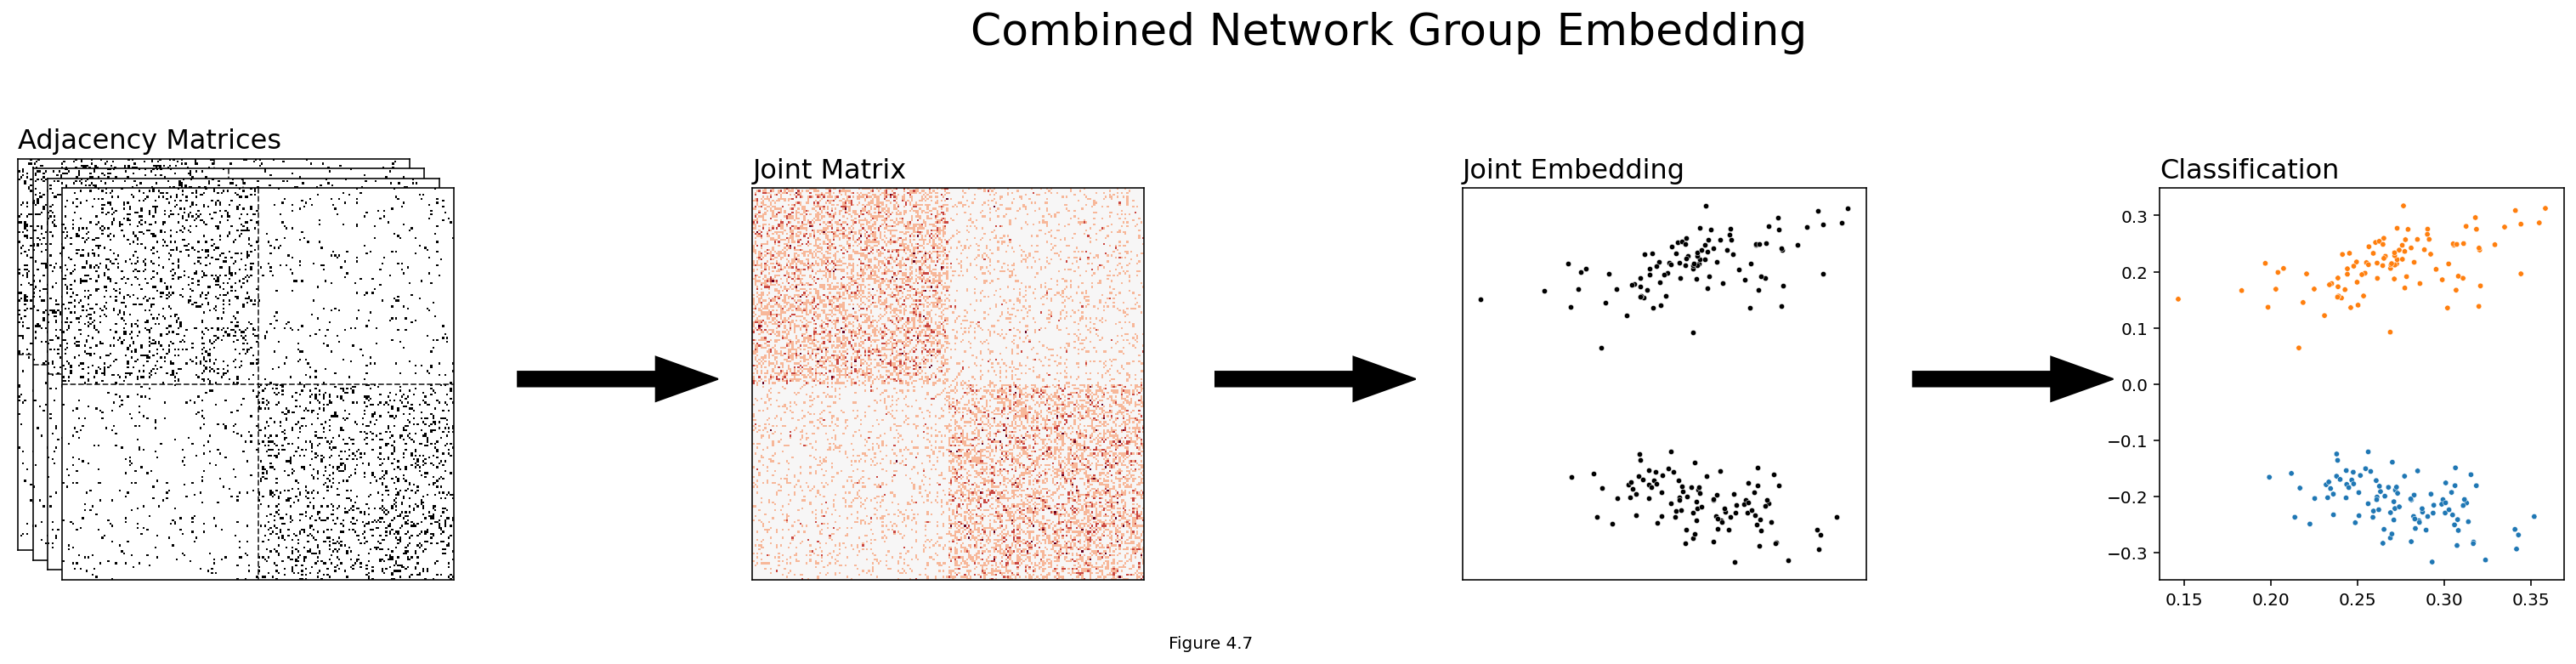

In [13]:
from graspologic.embed import MultipleASE as MASE
from graspologic.embed import OmnibusEmbed as OMNI
from graspologic.embed.omni import _get_omni_matrix
from graspologic.plot import heatmap
from graphbook_code import binary_heatmap

fig = plt.figure();

def rm_ticks(ax, x=False, y=False, **kwargs):
    if x is not None:
        ax.axes.xaxis.set_visible(x)
    if y is not None:
        ax.axes.yaxis.set_visible(y)
    sns.despine(ax=ax, **kwargs)
    
fig = plt.figure();

# add stack of heatmaps
for i in range(4):
    ax = fig.add_axes([.02*i, -.02*i, .8, .8]) 
    ax = binary_heatmap(humans[i], ax=ax, legend=False)
    if i == 0:
        ax.set_title("Adjacency Matrices", loc="left", fontsize=16)
    rm_ticks(ax, top=False, right=False)
    ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)


# add arrow
arrow_ax = fig.add_axes([.8, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add joint matrix
omni_ax = fig.add_axes([1, -.02*3, .8, .8])
A = human_mean_network.copy()
a_hm = heatmap(A, ax=omni_ax, cbar=False)
a_hm.set_title("Joint Matrix", loc="left", fontsize=16)
for _, spine in a_hm.spines.items():
    spine.set_visible(True)
    
# add second arrow
arrow_ax = fig.add_axes([1.75, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add averaged embedding
omni_embed_ax = fig.add_axes([2.1, -.02*3, .55, .8])
plot_latents(human_latents, ax=omni_embed_ax, title="Joint Embedding", 
             fontdict={'fontsize': 16})
rm_ticks(omni_embed_ax, top=False, right=False)

# add third arrow
arrow_ax = fig.add_axes([2.7, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# classify
mase_ax = fig.add_axes([3.05, -.02*3, .55, .8])
plot_latents(human_latents, ax=mase_ax, title="Classification", 
             fontdict={'fontsize': 16}, labels=human_labels, legend=False);

plt.suptitle("Combined Network Group Embedding", x=2, y=1.1, fontsize=26);
plt.figtext(1.7, -.2, "Figure 4.7")

### Combining The Networks Separately

The above approach is nice for collapsing our information into a single embedding -- with each point in our final embedding representing a single node of our network. However, there are situations in which we might want to keep our embeddings separate, but make sure that they're in the same latent space -- meaning, the embeddings aren't rotations of each other. That way, we can directly compare the embeddings of our separate embeddings.

Text(1.7, -0.2, 'Figure 4.8')

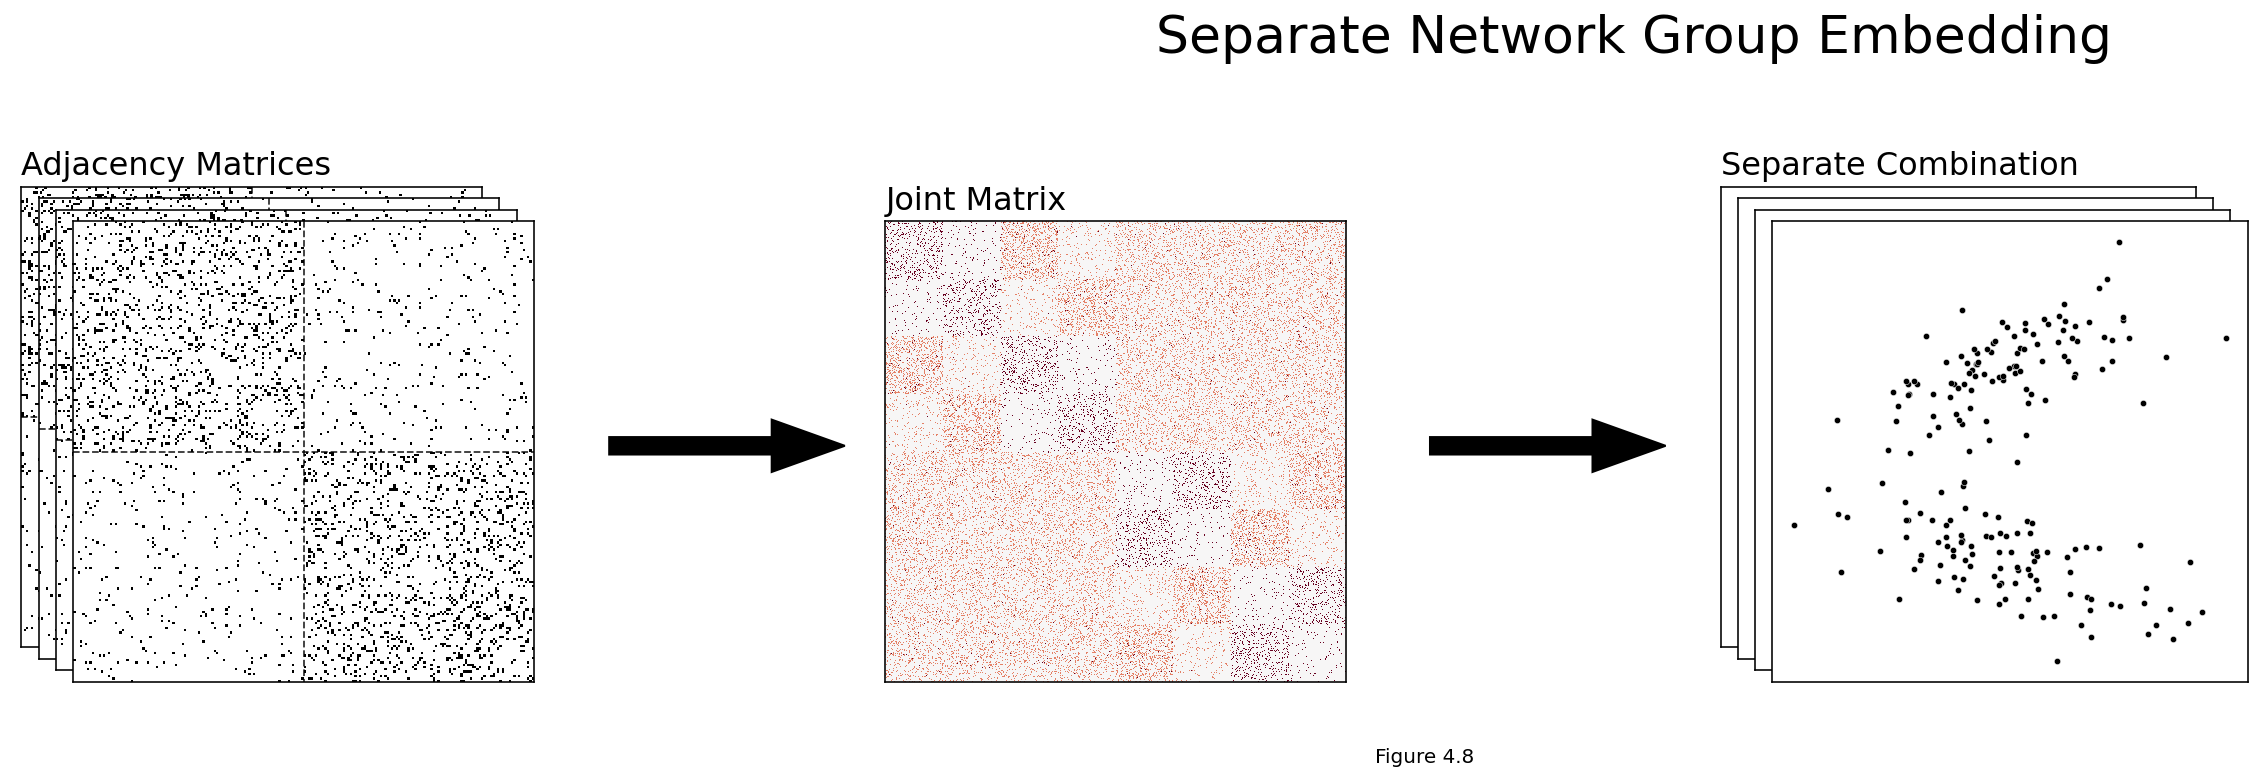

In [14]:
from graspologic.embed import MultipleASE as MASE
from graspologic.embed import OmnibusEmbed as OMNI
from graspologic.embed.omni import _get_omni_matrix
from graspologic.plot import heatmap

def rm_ticks(ax, x=False, y=False, **kwargs):
    if x is not None:
        ax.axes.xaxis.set_visible(x)
    if y is not None:
        ax.axes.yaxis.set_visible(y)
    sns.despine(ax=ax, **kwargs)
    
fig = plt.figure();

# add stack of heatmaps
for i in range(4):
    ax = fig.add_axes([.02*i, -.02*i, .8, .8]) 
    ax = binary_heatmap(humans[i], ax=ax, legend=False)
    if i == 0:
        ax.set_title("Adjacency Matrices", loc="left", fontsize=16)
    rm_ticks(ax, top=False, right=False)
    ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)

# add arrow
arrow_ax = fig.add_axes([.8, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add joint matrix
omni_ax = fig.add_axes([1, -.02*3, .8, .8])
A = _get_omni_matrix(humans[:2]+aliens[:2])
a_hm = heatmap(A, ax=omni_ax, cbar=False)
a_hm.set_title("Joint Matrix", loc="left", fontsize=16)
for _, spine in a_hm.spines.items():
    spine.set_visible(True)
    
# add second arrow
arrow_ax = fig.add_axes([1.75, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add omni embedding
latents_omni = OMNI(n_components=2).fit_transform(humans[:2]+aliens[:2])
for i, embedding in enumerate(latents_omni):
    ax = fig.add_axes([2.1+.02*i, -.02*i, .55, .8])
    if i == 0:
        ax.set_title("Separate Combination", loc="left", fontsize=16)
    plot = sns.scatterplot(embedding[:, 0], embedding[:, 1], 
                       s=10, ax=ax, color="black")
    rm_ticks(ax, top=False, right=False)
    
plt.suptitle("Separate Network Group Embedding", x=2, y=1.1, fontsize=26);
plt.figtext(1.7, -.2, "Figure 4.8")

### Combining the embeddings

The final approach to multiple-network representation learning that we'll talk about is combining the embeddings themselves. With this approach, you're waiting until you've already embnedded all of your networks separately before you combine them, either with Adjacency Spectral Embedding or with some other single-network embedding method. Multiple Adjacency Spectral Embedding, which we'll be talking about soon, is an example of this approach.

Text(1.7, -0.2, 'Figure 4.9')

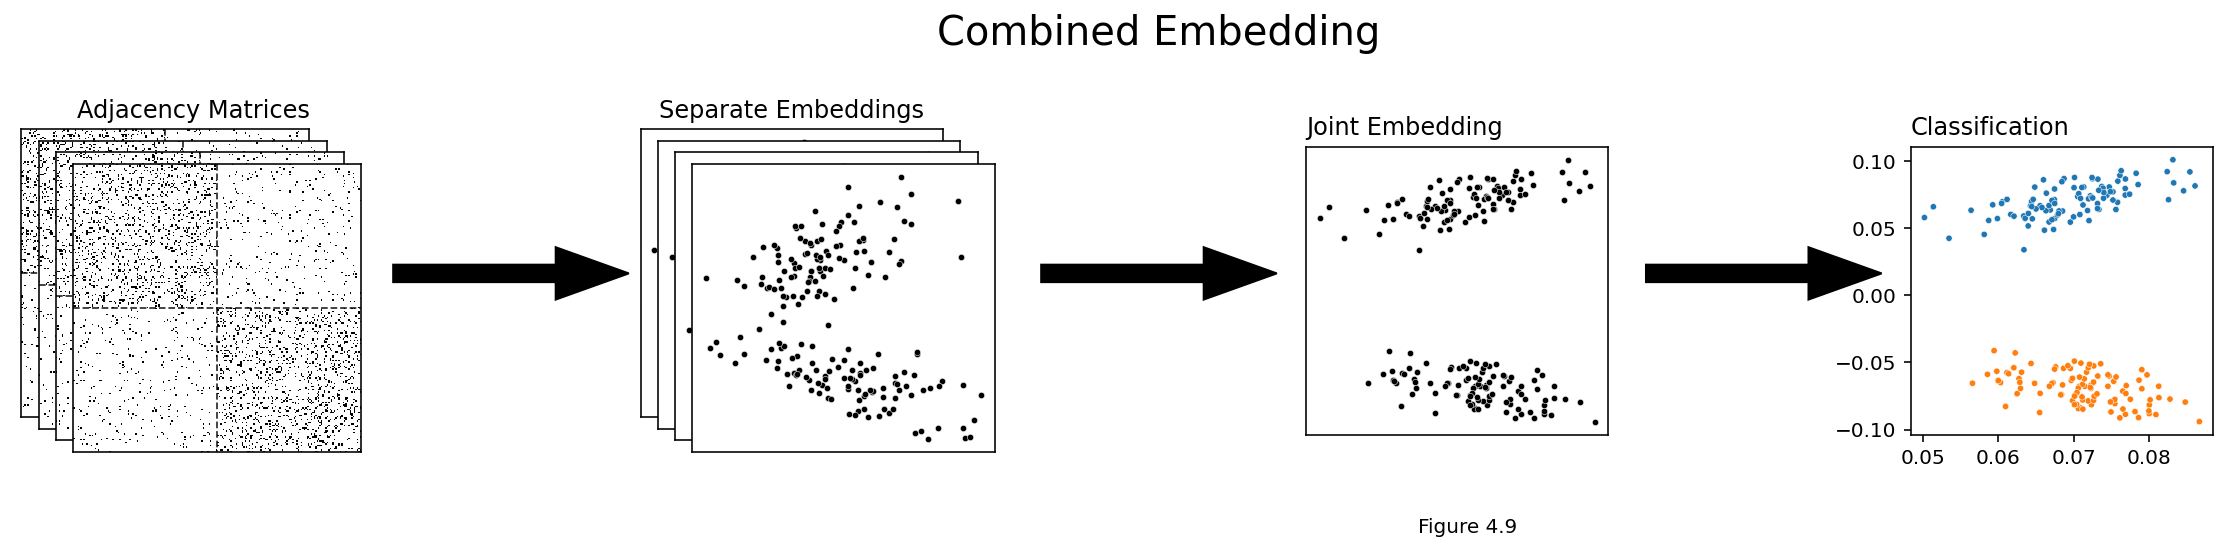

In [15]:
fig = plt.figure()

# add stack of heatmaps
for i in range(4):
    ax = fig.add_axes([.02*i, -.02*i, .5, .5]) 
    ax = binary_heatmap(humans[i], ax=ax, legend=False)
    if i == 0:
        ax.set_title("Adjacency Matrices", loc="right")
    rm_ticks(ax, top=False, right=False)
    ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)

# add arrow
arrow_ax = fig.add_axes([.5, .2, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add stack of latent plots
for i in range(4):
    ax = fig.add_axes([.8+.02*i, -.02*i, .35, .5])
    if i == 0:
        ax.set_title("Separate Embeddings")
    latents = ase.fit_transform(humans[i])
    plot = sns.scatterplot(latents[:, 0], latents[:, 1], 
                       s=10, ax=ax, color="black")
    rm_ticks(ax, top=False, right=False)
    
# add second arrow
arrow_ax = fig.add_axes([1.25, .2, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add group embeddings
mase = MASE(n_components=2)
latents_mase = mase.fit_transform(humans + aliens)
mase_ax = fig.add_axes([1.57, -.03, .35, .5])
plot_latents(latents_mase, ax=mase_ax, title="Joint Embedding")
rm_ticks(mase_ax, top=False, right=False)

# add third arrow
arrow_ax = fig.add_axes([1.95, .2, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# classify
labels_normal = GMM(n_components=2).fit_predict(human_latents)
mase_ax = fig.add_axes([2.27, -.03, .35, .5])
plot_latents(latents_mase, ax=mase_ax, title="Classification", 
             labels=labels_normal, legend=False)

plt.suptitle("Combined Embedding", x=1.4, y=.7, fontsize=20);
plt.figtext(1.7, -.2, "Figure 4.9")

For the rest of this section, we'll explore the strengths and weaknesses of different particular techniques which use these approaches. The first we'll look at is combines the embeddings, like above. It's called Multiple Adjacency Spectral Embedding, or MASE for short.

## Multiple Adjacency Spectral Embedding

MASE is a technique which combines embeddings by concatennating and re-embedding the separate latent positions into a single space. It's nice because you don't actually need each network to be generated from the same distribution - you only need the nodes of the different networks to be aligned and for them to belong to the same communities.

MASE is probably the easiest to understand if you know how Adjacency Spectral Embeddings work. Say you have some number of networks, and (like we said above) their nodes are aligned. The goal of MASE is to embed the networks into a single space, with each point in that space representing a single node - but, unlike simply averaging, MASE lets you combine networks which aren't necessarily drawn from the same distribution. MASE is based on the common subspace independent-edge (COSIE) model from the multi-network models section of chapter 5, so we're operating under the assumption that there *is* some low-dimensional space common to all of our networks that we can embed into in the first place.

Let's go back to our group of human and alien brains and try using MASE to embed them rather than averaging. Then, we'll dive deeper into what's going on under the hood. First, we'll instantiate a MASE classifier and embed down to two dimensions. Then we'll create a combined list of the human and alien brains, and use MASE to find the latent positions.

In [16]:
from graspologic.embed import MultipleASE as MASE

# Use MASE to embed everything
mase = MASE(n_components=2)
latents_mase = mase.fit_transform(humans + aliens)

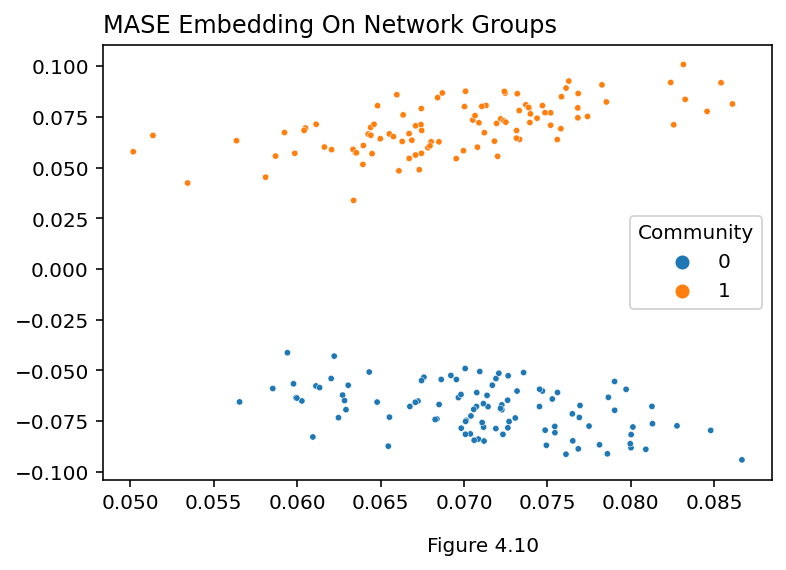

In [17]:
plot_latents(latents_mase, 
             title="MASE Embedding On Network Groups", 
             labels=labels);

plt.figtext(0.5, 0, "Figure 4.10");

Unlike the disastrous results from simply averaging all of our networks together, MASE manages to keep the community structure that we found when we averaged our networks separately. Let's see what's under the hood.

### Overview of MASE

Below, you can see how MASE works. We start with networks, drawn as nodes in space connected to each other. We turn them into adjacency matrices, and then we embed the adjacency matrices of a bunch of networks separately, using our standard Adjacency Spectral Embedding. Then, we take all of those embeddings, concatenate horizontally into a single matrix, and embed the entire concatenated matrix. The colors are the true communities each node belongs to: there's a red and an orange community. MASE is an unsupervised learning technique and so it doesn't need any information about the true communities to embed, but they're useful to see.

```{figure} ../../Images/mase1.jpeg
---
height: 400px
name: mase-fig
---
The MASE algorithm
```

#### A Collection of Networks

We'll illustrate what's happening in the MASE algorithm by running through all of its steps ourselves, with a set of example networks.

Suppose we have a set of networks generated from Stochastic Block Models with two communities in each network. The networks have aligned nodes -- meaning that the $i_{th}$ row of all of their adjacency matrices represent the edges for the same node $i$. The nodes also all belong to the same communities. However, edge probabilities might change depending on the network. In the first network, you might have nodes in the same community having a high chance of connecting to each other, whereas in the second network, nodes are much more likely to be connected to other nodes in different communities. You want to end up with a classification that distinctly groups the nodes into their respective communities, using the information from all of the networks. Because MASE takes approach of combining the embeddings, we start by embedding each network separately with an Adjacency Spectral Embedding.

Below is Python code which generates four networks with Stochastic Block Models. Each of the networks is drawn from a different distribution (the block probability matrices are different), but the labels are the same across the networks (which means that nodes have a consistent community no matter which network you're looking at). If you're interested in the particular parameters used to generate these SBMs, you can see them in the code below.

In [18]:
import numpy as np
from graspologic.simulations import sbm

n = 100
p1, p2, p3 = .12, .06, .03
A1, labels = make_sbm(p1, p3, p3, p1, 
                      return_labels=True)
A2 = make_sbm(p1, p3, p3, p2)
A3 = make_sbm(p3, p2, p2, p3)
A4 = make_sbm(p1, p3, p3, p3)

networks = [A1, A2, A3, A4]

Text(0.5, 0, 'Figure 4.11')

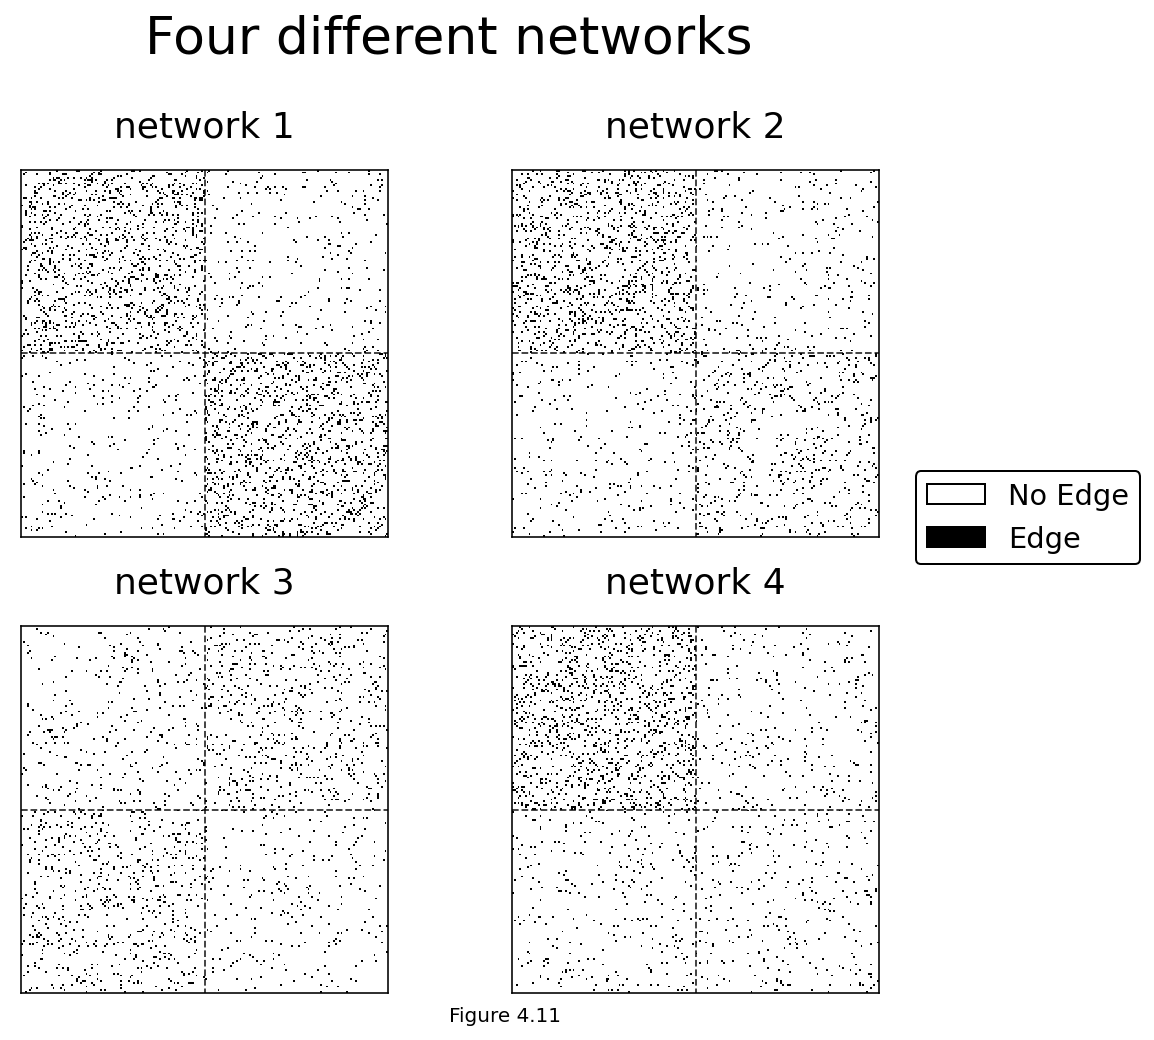

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(7,7))
for i, (ax, graph) in enumerate(zip(axs.flat, networks)):
    hmap = binary_heatmap(graph, ax=ax, legend=False, title=f"network {i+1}")
    for spine in ax.spines.values():
        spine.set_visible(True)
    hmap.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    hmap.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    
plt.suptitle("Four different networks", fontsize=26, y=1)
fig.subplots_adjust(hspace=.05, wspace=.05)

add_legend(A1, bbox_to_anchor=(1.2, .5))

plt.tight_layout()
plt.figtext(0.5, 0, "Figure 4.11")

#### Embedding our networks

Next, we embed each of the four networks separately using Adjacency Spectral Embedding. This step is pretty straightforward, so we won't dive into it too much: remember, we're combining the embeddings, not the networks, so we're not doing anything fancy. The python code below just groups the four networks into a list, and then loops through the list, embedding each network into two dimensions and saving the resulting embeddings into a variable.

In [20]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

networks = [A1, A2, A3, A4]
latents_mase = []
for network in networks:
    ase = ASE(n_components=2)
    latent = ase.fit_transform(network)
    latents_mase.append(latent)

Text(0.5, -0.05, 'Figure 4.13')

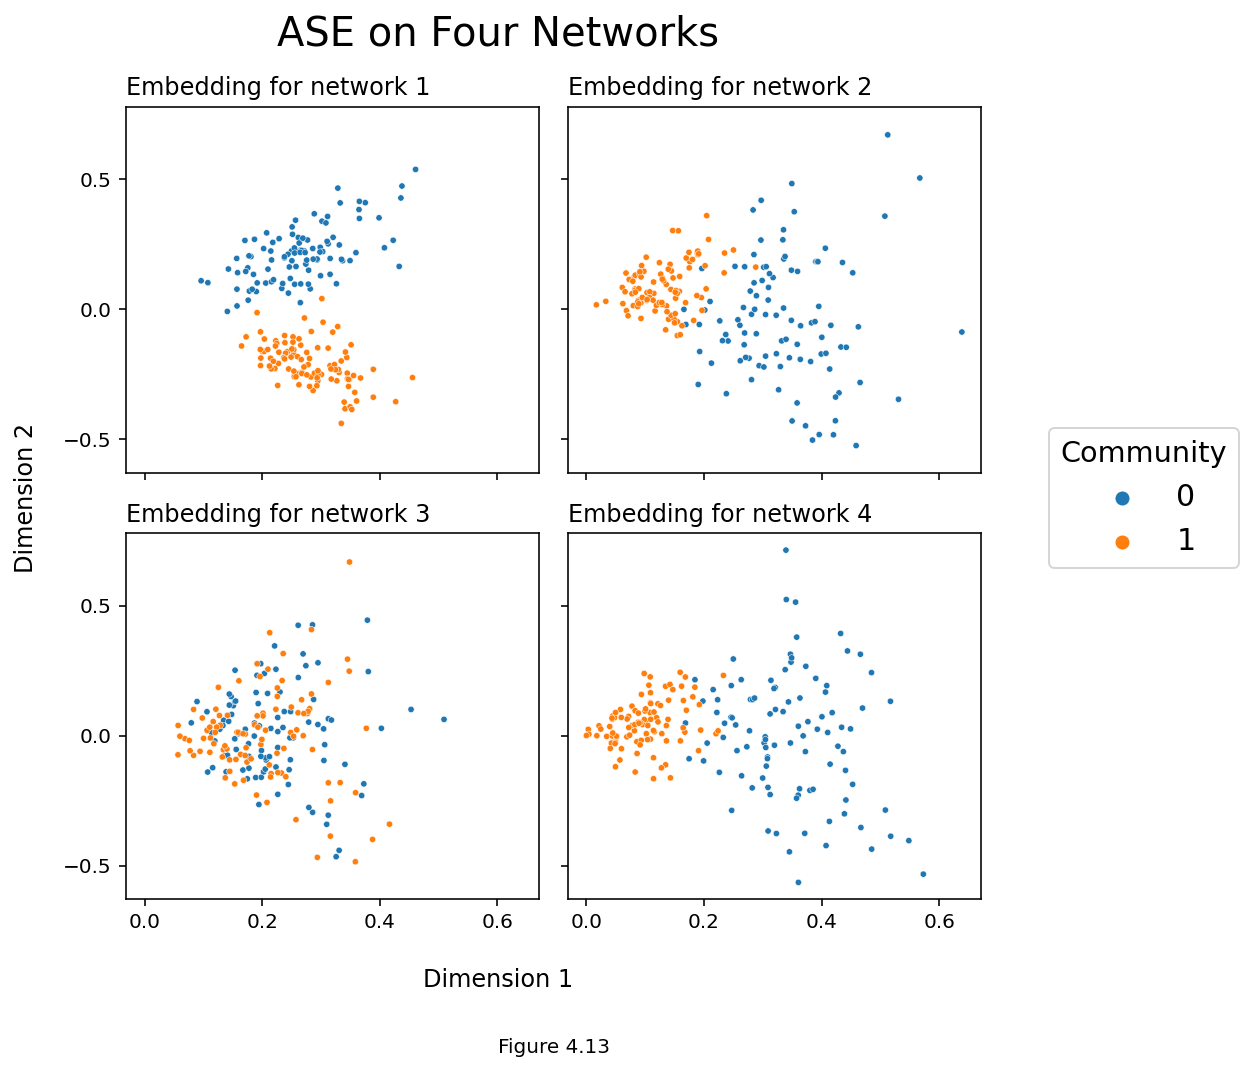

In [21]:
%autoreload 2
from graphbook_code import plot_latents

fig, axs = plt.subplots(2, 2, figsize=(7,7), sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    plot_latents(latents_mase[i], title=f"Embedding for network {i+1}", 
                 labels=labels, ax=ax, legend=False)
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.suptitle("ASE on Four Networks", fontsize=20);

h, l = ax.get_legend_handles_labels()
fig.legend(h, l, loc='center right', bbox_to_anchor=(1.25, .5), 
           prop={'size': 15}, title="Community", title_fontsize='x-large');

fig.supxlabel("Dimension 1")
fig.supylabel("Dimension 2");

plt.tight_layout()
plt.figtext(0.5, -.05, "Figure 4.13")

It's important to keep in mind that these embeddings don't live in the same *latent space*. What this means is that averaging these networks together would result in essentially meaningless noise. This is because of the rotational invariance of latent positions: you can only recover the latent positions of any network up to a rotation. 

#### Combining our embeddings

Now comes the interesting part. Our goal is to find some way to take each of these individual embeddings and combine them. We want to find a reasonable way of doing this.

We can visualize each of our four embeddings a different way. Instead of the using the two latent position dimensions as the x-axis and the y-axis of our plot, we can just visualize our latent position matrices directly. Each latent position now corresponds to rows in one of these matrices. The two columns are the two latent position dimensions, and the two colors in each row corresponds to the latent position value. We're essentially substituting location for color.

Text(0.4, -0.05, 'Figure 4.13')

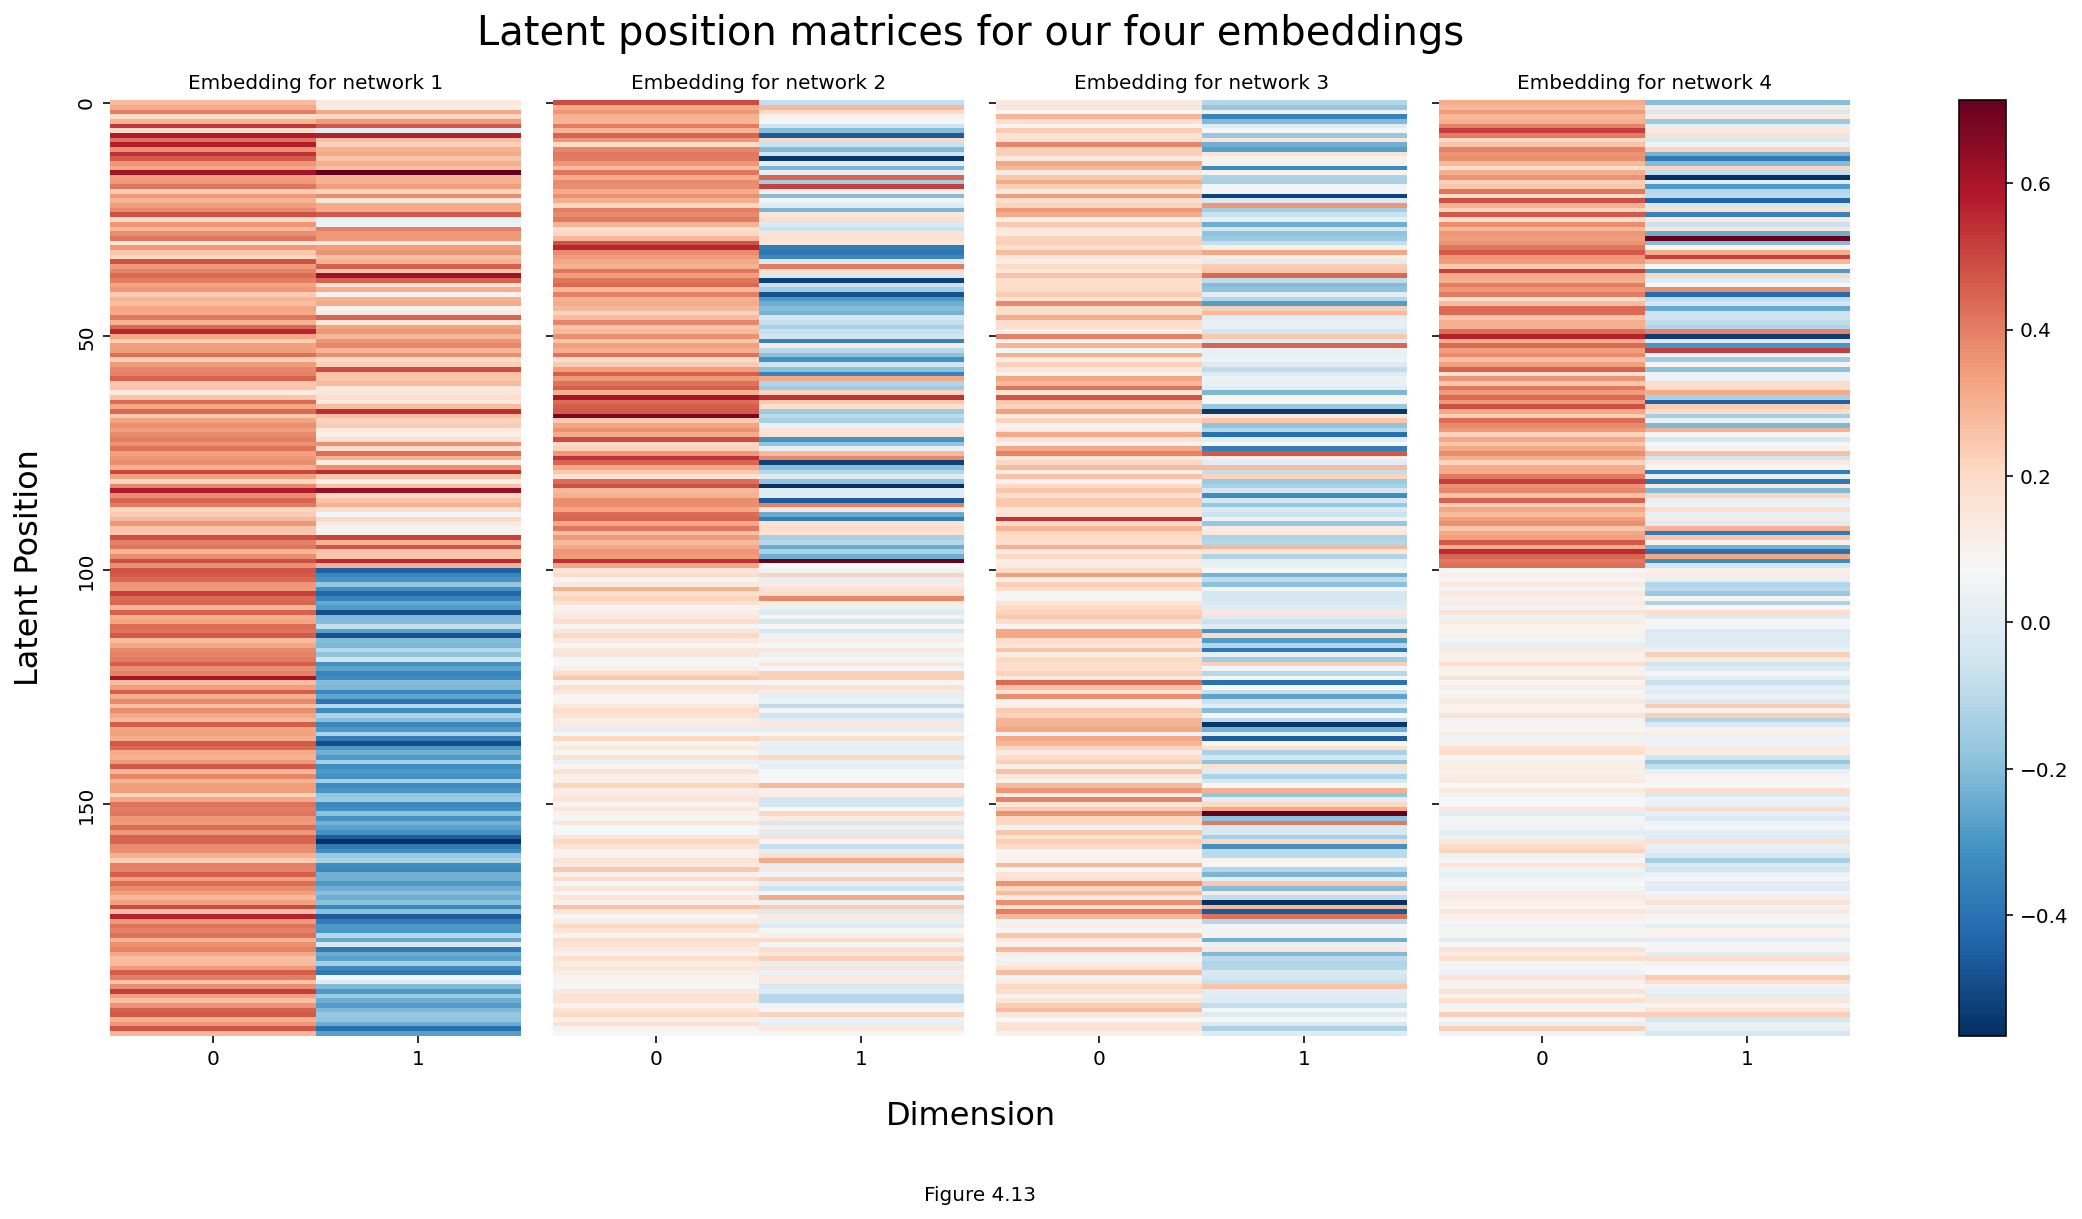

In [22]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from graphbook_code import GraphColormap

cmap = GraphColormap("divergent", discrete=False).palette
fig, axs = plt.subplots(ncols=4, figsize=(16, 8), sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    hm = sns.heatmap(latents_mase[i], cmap=cmap, 
                     ax=ax, yticklabels=50, cbar=False)
    hm.set_title(f"Embedding for network {i+1}", fontdict={'fontsize': 10})
    
fig.supxlabel("Dimension", x=.42, fontsize=16)
fig.supylabel("Latent Position", x=.005, fontsize=16)
fig.suptitle("Latent position matrices for our four embeddings", x=.42, fontsize=20)

fig.tight_layout(w_pad=2)
vmin, vmax = np.array(latents_mase).min(), np.array(latents_mase).max()
norm = Normalize(vmin=vmin, vmax=vmax)
im = cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(im, ax=axs);

plt.figtext(0.4, -.05, "Figure 4.13")

Because the rows of these matrices are all aligned - meaning, row 0 corresponds to node 0 for all four matrices - we can actually think of each node as having (in this case) eight latent position dimensions: two for each of our four networks. Eight is a somewhat arbitrary number here: each network contributes two dimensions simply because we originally chose to embed all of our networks down to two dimensions with ASE, and the number of networks is of course even more arbitrary. You'll usually have more than four.

In the more general sense, we can think of each node as having $m \times d$ latent position dimensions, where $m$ is the number of networks, and $d$ is the number of dimensions we embed each network into. We don't actually need separate matrices to express this idea: the natural thing to do would be to just concatenate all of the matrices horizontally into a single $m \times d$ matrix.

In [23]:
# Concatenate our four matrices horizontally into a single m by d matrix
concatenated = np.hstack(latents_mase)

Text(0.5, 0, 'Figure 4.14')

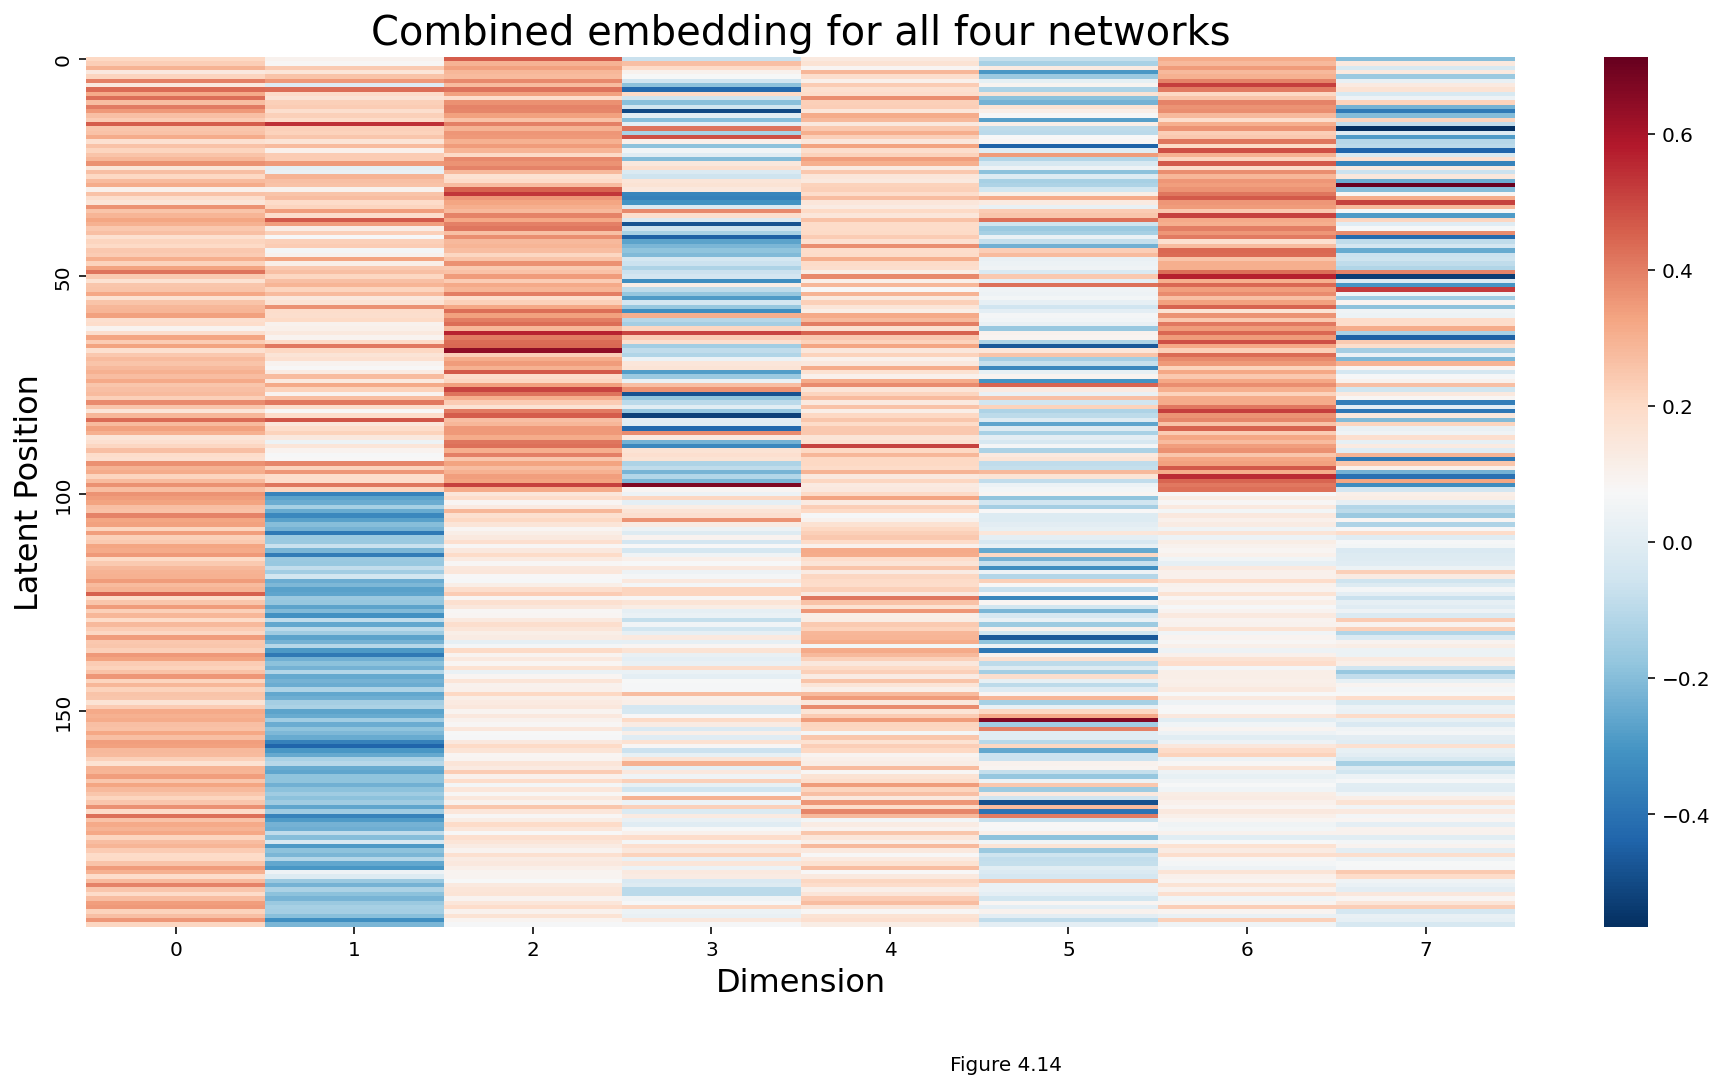

In [24]:
fig, ax = plt.subplots(figsize=(16, 8))
hm = sns.heatmap(concatenated, cmap=cmap, ax=ax, yticklabels=50);
hm.set_title(f"Combined embedding for all four networks", fontdict={'fontsize': 20});
hm.set_xlabel("Dimension", fontsize=16)
hm.set_ylabel("Latent Position", fontsize=16);

plt.figtext(0.5, 0, "Figure 4.14")

#### Embedding our Combination To Create a Joint Embedding

So now we have a combined representation for our separate embeddings, but we have a new problem: our latent positions suddenly have way too many dimensions. In this example they have eight (the number of columns in our combined matrix), but remember that in general we'd have $m \times d$. This somewhat defeats the purpose of an embedding: we took a bunch of high-dimensional objects and turned them all into a single high-dimensional object. Big whoop. We can't see what our combined embedding look like in euclidean space, unless we can somehow visualize $m \times d$ dimensional space (hint: we can't). We'd like to just have `d` dimensions - that was the whole point of using `d` components for each of our Adjacency Spectral Embeddings in the first place!

There's an obvious solution here: why don't we just embed *again*? Nothing stops us from doing a Singular Value Decomposition on a nonsquare matrix, and so we can just create a joint embedding of our combined matrix and go back down to a healthy $d$ columns.

In [25]:
from graspologic.embed import select_svd
joint_embedding, *_ = select_svd(concatenated, n_components=2)

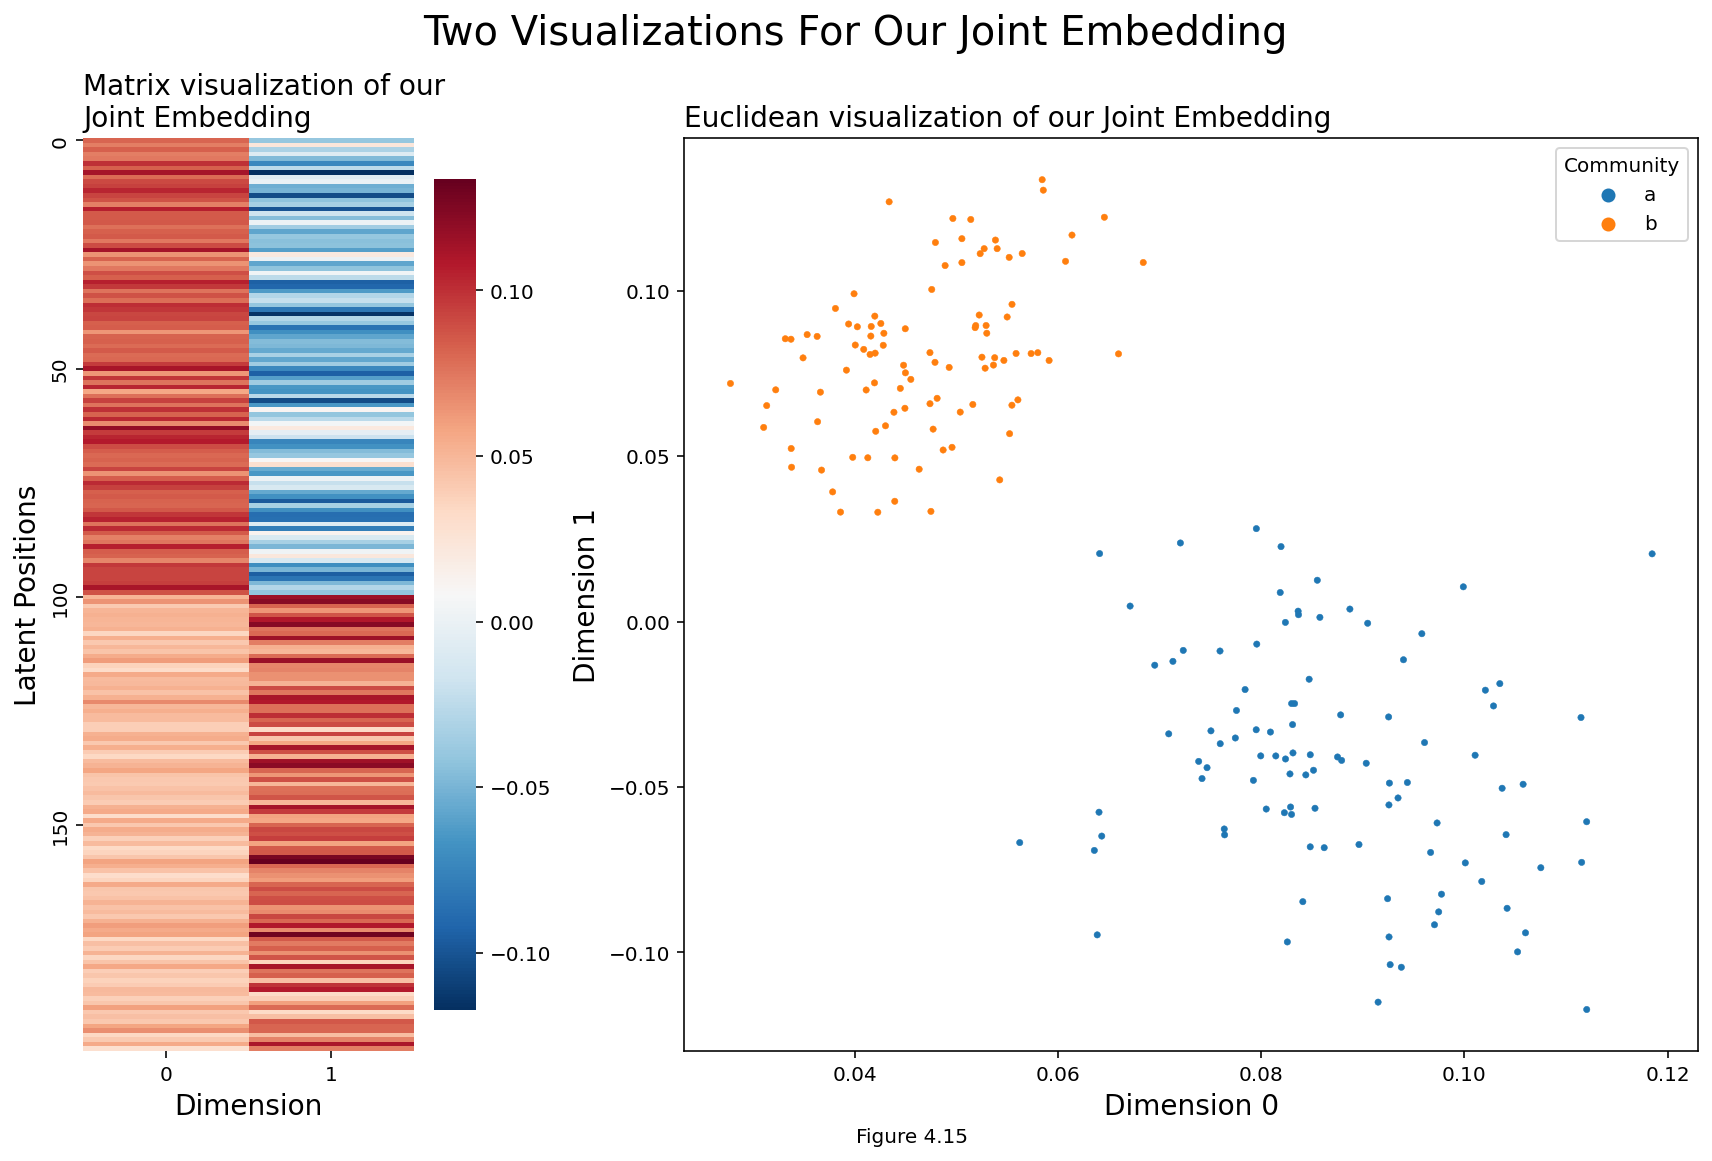

In [26]:
from matplotlib.gridspec import GridSpec
from graphbook_code import cmaps

# TODO: add legend
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(1, 3)
axm = fig.add_subplot(gs[0])
axs = fig.add_subplot(gs[1:])

# Matrix representation
hm = sns.heatmap(joint_embedding, cmap=cmap, ax=axm, yticklabels=50, cbar=True,
                 cbar_kws={"shrink": .91})
hm.set_title(f"Matrix visualization of our \nJoint Embedding", fontdict={'fontsize': 14}, loc='left')
hm.set_xlabel("Dimension", fontdict={"fontsize": 14})
hm.set_ylabel("Latent Positions", fontdict={"fontsize": 14})

# Euclidean representation
splot = sns.scatterplot(joint_embedding[:, 0], joint_embedding[:, 1], ax=axs, hue=labels,
                        palette=cmaps["qualitative"], edgecolor=None, s=10)
splot.set_xlabel("Dimension 0", fontdict={"fontsize": 14})
splot.set_ylabel("Dimension 1", fontdict={"fontsize": 14})
splot.set_title("Euclidean visualization of our Joint Embedding", loc="left", fontdict={"fontsize": 14})
h, l = splot.get_legend_handles_labels()
splot.legend(title='Community', handles=h, labels=["a", "b"])

# fig title
plt.suptitle("Two Visualizations For Our Joint Embedding", fontsize=20)
plt.tight_layout()

plt.figtext(0.5, 0, "Figure 4.15");

Looks like this idea worked well - Our nodes are clearly grouped into two distinct communities, and all of our networks were drawn from the same distribution! To reiterate, what we did was:
1. Embed each of our four networks separately into two-dimensional space
2. Think of all of the resulting latent positions for a particular node as a single vector
3. With the intuition from 2, horizontally concatenate our four latent position matrices into a single matrix
4. embed that new matrix down to 2 dimensions

### Using Graspologic

In practice, you don't actually have to implement any of this stuff yourself. Graspologic's MultipleASE class implements it all for you under the hood. You can see the embedding below - you give MultipleASE a list of networks, and it spits out a set of joint latent positions. Graspologic's implementation of MASE is doing pretty much exactly what we just did: it embeds all of the networks you pass in, concatenates them horizontally, and then re-embeds the concatenated matrix. You can see this in the figure -- MASE's embedding looks just like the one we made above.

In [27]:
from graspologic.embed import MultipleASE as MASE

mase = MASE(n_components=2)
latents = mase.fit_transform(networks)

Text(0.5, 0, 'Figure 4.16')

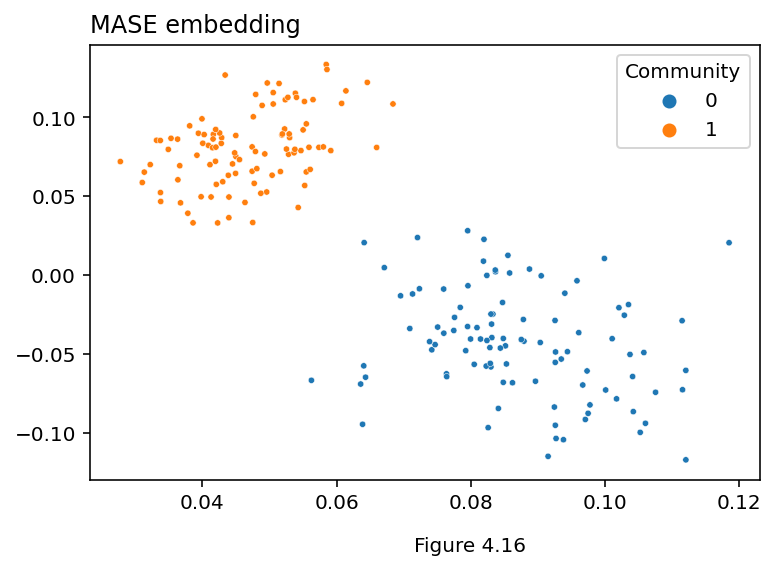

In [28]:
plot_latents(latents, title="MASE embedding", labels=labels);
plt.figtext(0.5, 0, "Figure 4.16")

### Score Matrices*

Exactly how is the joint embedding we created related to all of separate, original networks? Well, to understand this, we need to introduce the concept of *score matrices*.

In MASE, each network is associated with its own score matrix. Just like the joint embedding describes how the networks are similar, the score matrices describe how each network is different.

Suppose we have a set of networks with adjacency matrices $A^{(1)}, ..., A^{(m)}$, with each network being unweighted. In the joint embedding we made before, for instance, we had $m=4$. 

Now, we run MASE using the method described above, and we get a joint embedding $V$. Then each adjacency matrix, $A^{(i)}$, can be decomposed into $VR^{(i)} V^\top$, where $R^{(i)}$ is the score matrix corresponding to the $i_{th}$ network:

\begin{align*}
    A^{(i)} = VR^{(i)} V^\top
\end{align*}

This is how the score matrix of a particular network $R^{(i)}$ and the single joint embedding $V$ is related to the original network $A^{(i)}$. 

#### Finding Score Matrices

Any particular score matrix, $R^{(i)}$, is square and $d \times d$. The dimension, $d$, corresponds to the number of embedding dimensions -- so if we wanted to embed down to two dimensions, each $R^{(i)}$ would be a $2 \times 2$ matrix. 

Now, here's the interesting part: how do we find our score matrices? Well, there's a theorem in linear algebra about matrices which are *orthogonal*, meaning that the columns all perpendicular to each other. This theorem says that the inverse of an orthogonal matrix is its transpose. So, for an orthogonal matrix $O$,

\begin{align*}
    O^\top = O^{-1}
\end{align*}

Interestingly, the column-vectors of our joint embedding matrix (let's call it $V$) are all perpendicular. Since definitionally, what it means for two vectors to be perpendicular is that they have a dot product of 0, we can check this below:

In [29]:
V = joint_embedding.copy()

# Take the dot product of the columns of our joint latent position matrix
np.round(V[:, 0] @ V[:, 1])

0.0

What this all means is that $V^\top V$ is just the identity matrix $I$.

In [30]:
np.round(V.T@V)

array([[1., 0.],
       [0., 1.]])

and so, finally, we can use the above two facts to find the score matrix for a particular network. We just take our original formula $A^{(i)} = VR^{(i)} V^\top$, left-multiply by $V^\top$, and right-multiply by $V$.

\begin{align*}
    A^{(i)} &= VR^{(i)} V^\top \\
    V^{\top} A^{(i)} V &= (V^\top V) R^{(i)} (V^\top V) \\
    V^\top A^{(i)} V &= R^{(i)} 
\end{align*}

Below, we turn the list of four networks we already embedded into a 3-D numpy array, and then do the above multiplication to get a new 3D numpy array of scores matrices. Because we embedded into two dimensions, each score matrix is $2 \times 2$, and the four score matrices are "slices" along the 0th axis of the numpy array.

In [31]:
networks_array = np.asarray(networks)
scores = V.T @ networks_array @ V
scores.shape

(4, 2, 2)

Now, here's something interesting: it turns out that we can estimate the edge probability matrix which generated any graph with $ P^{(i)} = V R^{(i)} V^\top$.

In [32]:
P_0 = V @ scores[0] @ V.T

Below and to the left, you can see the original adjacency matrix for the first matrix. In the center, you can see the heatmap for the first network's score matrix. Next to it, you can see the recreation of the first network. Remember that we only used the score matrix to recreate it. The first network has a block probability matrix of

\begin{align}
\begin{bmatrix}
.12 & .03 \\
.03 & .06 \\
\end{bmatrix}
\end{align}

and so we should expect the edges in the top-left block of our adjacency matrix to be more connected, the edges in the two off-diagonal blocks to not be very connected, and the edges in the bottom-right block to be kind of connected.

Text(0.5, -0.05, 'Figure 4.17')

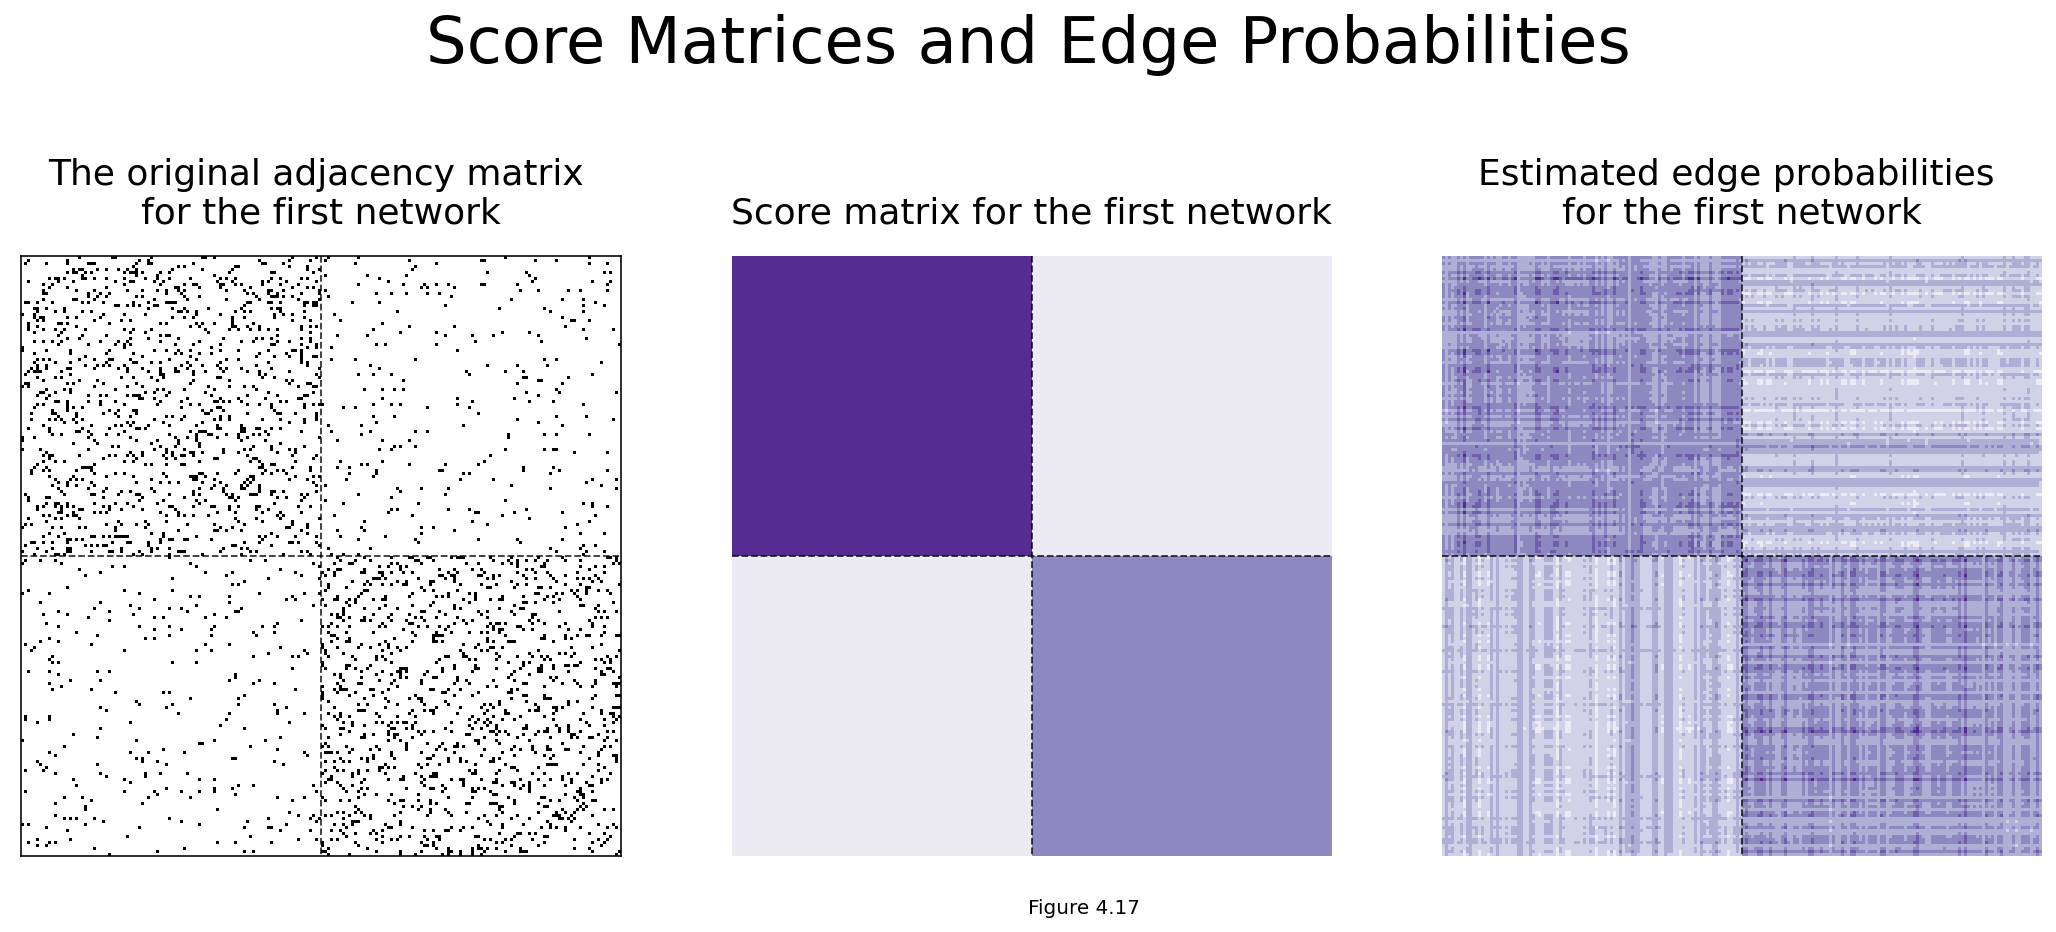

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

lined_heatmap(networks[0], title="The original adjacency matrix \nfor the first network",
               ax=axs[0], legend=False)
lined_heatmap(scores[0], binary=False, cbar=False, title="Score matrix for the first network", ax=axs[1])
lined_heatmap(P_0, binary=False, cbar=False, title="Estimated edge probabilities \nfor the first network", ax=axs[2])

plt.tight_layout()
fig.suptitle("Score Matrices and Edge Probabilities", fontsize=32, y=1.2);
plt.figtext(0.5, -.05, "Figure 4.17")

So we've learned that MASE is useful when you want a joint embedding that combines all of your networks together, and when you want to estimate edge probabilities for one of your networks. What if we wanted to keep our separate embeddings, but put them all in the same space? That's what the Omnibus Embedding gives, and what we'll explore now.

## Omnibus Embedding

The Omnibus Embedding combines networks separately to put them all into the same latent space. What this means is that the embeddings for each network after the omnibus embedding are *directly comparable*: none of the embeddings are rotations of each other, and distances between nodes across embeddings actually means something. You can use the omnibus embedding to answer a variety of questions about the interacting properties of a collection of networks. For example, you could figure out which nodes or subgraphs are responsible for similarities or differences across your networks, or you could determine whether subcommunities in your networks are statistically similar or different. You could try to figure out which underlying parameters of your network are the same, and which are different.

In the next section, we'll explore how the Omnibus Embedding works. Sections in future chapters will explore some the things you can do with your separate embeddings to learn about your networks.

### OMNI on our four networks

We'll begin with an example. Let's go back to the four networks we created in the MASE section and look at their embeddings. Notice that the way the blue cluster of points and the red cluster of points is rotated is somewhat arbitrary across the embeddings for our different networks - this is because of the nonidentifiability problem in spectral embeddings.

```{admonition} Non-Identifiability
Let's take a network generated from an RDPG with $n$ nodes. Each of these $n$ nodes is associated with a latent position vector, corresponding to that node's row in the network's embedding. What it means for a node to have a latent position vector is that the probability for an edge to exist between two nodes $i$ and $j$ is the dot product of their latent position vectors.

More specifically, if $\textbf{P}$ is a matrix of edge probabilities, and $\textbf{X}$ is our latent position matrix, then $\textbf{P} = \textbf{X} \textbf{X}^\top$.

The nonidentifiability problem is as follows: Take any orthogonal matrix (a matrix which only rotates or flips other matrices). Call it $\textbf{W}$. By definition, the transpose of any orthogonal matrix is its inverse: $\textbf{W} \textbf{W}^\top = \textbf{I}$, where $\textbf{I}$ is the identity matrix. So,

\begin{align}
P &= \textbf{X} \textbf{X}^\top \\
  &= \textbf{X} \textbf{I} \textbf{X}^\top \\
  &= (\textbf{X} \textbf{W}) (\textbf{W}^\top \textbf{X}^\top) \\
  &= (\textbf{X} \textbf{W}) (\textbf{X} \textbf{W})^\top \\
\end{align}

What this means is that you can take any latent position matrix and rotate it, and the rotated version will still generate the same matrix of edge probabilities. So, when you try to estimate latent positions, separate estimations can produce rotated versions of each other.

You need to be aware of this in situations where you're trying to directly compare more than one embedding. You wouldn't be able to figure out the average position of a node, for instance, when you have multiple embeddings of that node.
```

You can see the nonidentifiability problem in action below. The embeddings for network 1 and for network 2 are particularly illustrative; community 0 is generally top in network 1, but on the right in network two. There isn't a way to compare any two nodes directly. Another way to say this is that, right now, all of our embeddings live in different *latent spaces*: direct comparison between embeddings for nodes in network 1 and nodes in network 2 isn't possible. You can also see the latent position corresponding to the first node as a big red circle in each network so that you can track a single point - you can see that the red points are likely to be rotated or flipped across networks.

Text(0.5, -0.05, 'Figure 4.18')

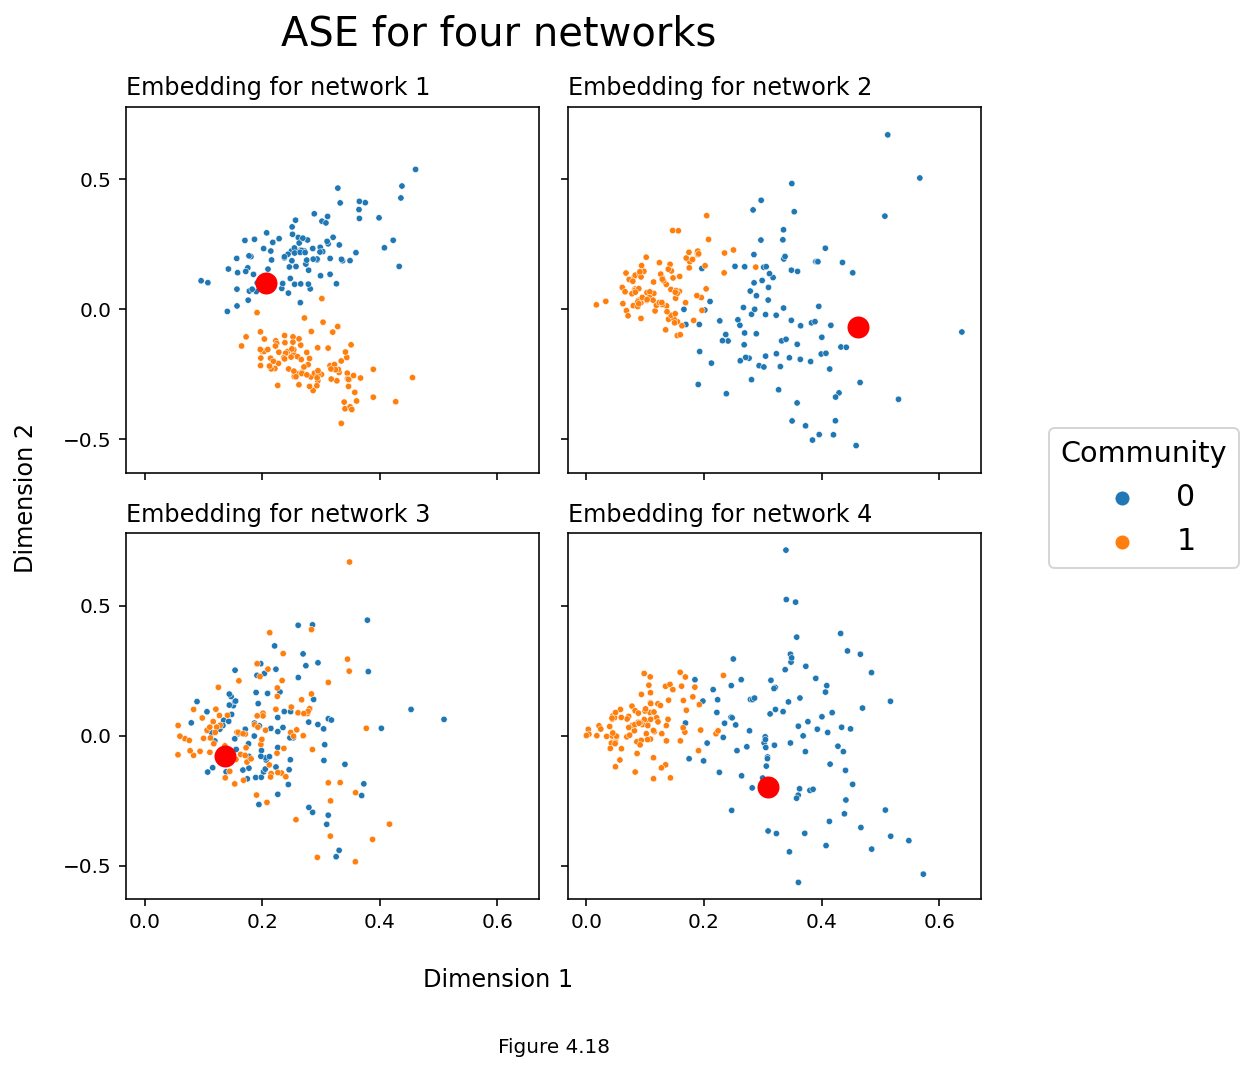

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(7,7), sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    plot_latents(latents_mase[i], title=f"Embedding for network {i+1}", 
                 labels=labels, ax=ax, legend=False)
    _x, _y = np.array(latents_mase)[i, 0]
    ax.plot(_x, _y, 'ro', markersize=10)
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.suptitle("ASE for four networks", fontsize=20);

h, l = ax.get_legend_handles_labels()
fig.legend(h, l, loc='center right', bbox_to_anchor=(1.25, .5), 
           prop={'size': 15}, title="Community", title_fontsize='x-large');

fig.supxlabel("Dimension 1")
fig.supylabel("Dimension 2");

plt.tight_layout()
plt.figtext(0.5, -.05, "Figure 4.18")

### OMNI on our four heterogeneous networks

Let's see what happens when, instead of embedding our networks separately as above, we find their latent positions with an Omnibus Embedding. Again, we'll plot a particular node with a circle so that we can track it across embeddings.

In [35]:
from graspologic.embed import OmnibusEmbed

omni = OmnibusEmbed(n_components=2)
latents_omni = omni.fit_transform(networks)

Text(0.5, -0.05, 'Figure 4.19')

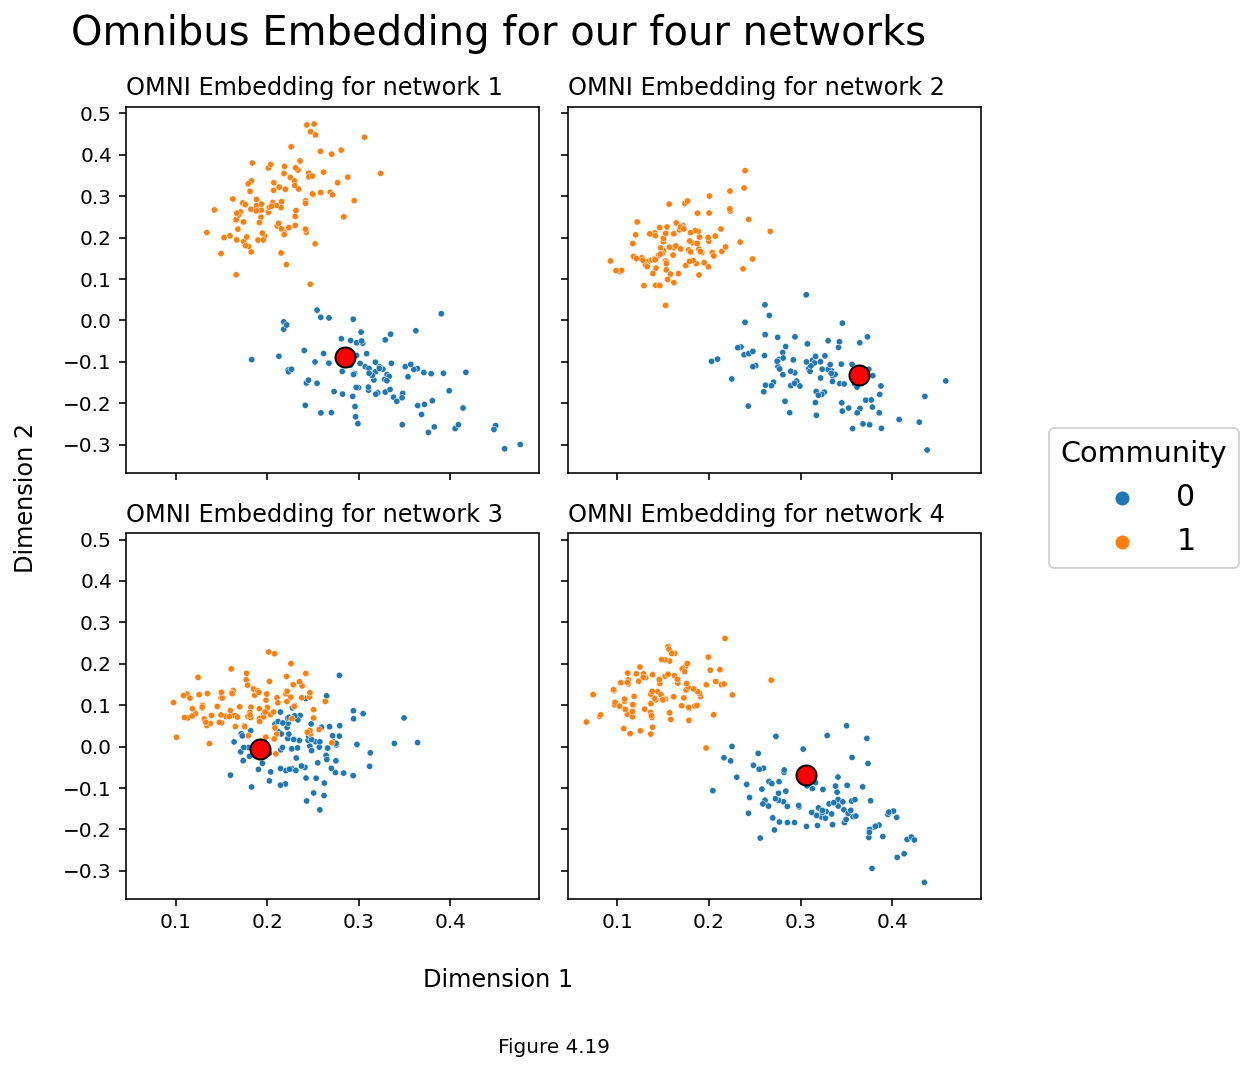

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(7,7), sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    plot_latents(latents_omni[i], title=f"OMNI Embedding for network {i+1}", 
                 labels=labels, ax=ax, legend=False)
    _x, _y = latents_omni[i, 0]
    ax.plot(_x, _y, 'ro', markersize=10, linewidth=1, markeredgecolor='k')

plt.suptitle("Omnibus Embedding for our four networks", fontsize=20);
h, l = ax.get_legend_handles_labels()
fig.legend(h, l, loc='center right', bbox_to_anchor=(1.25, .5), 
           prop={'size': 15}, title="Community", title_fontsize='x-large');
    
fig.supxlabel("Dimension 1")
fig.supylabel("Dimension 2");

plt.tight_layout()
plt.figtext(0.5, -.05, "Figure 4.19")

Unlike when we embedded the four networks separately, the clusters created by the Omnibus Embedding *live in the same space*: you don't have to rotate or flip your points to line them up across embeddings. The cluster of blue points is always in the top left, and the cluster of red points is always in the bottom right. This means that we can compare points directly; the relative location of the node in your network corresponding to the red circle, for instance, now means something across the four networks, and we can do stuff like measure the distance of the red circle in network 1 to the red circle in network two to gain information.

### Overview of OMNI

At a high level, the omnibus embedding is fairly simple. It:
1. Combines the adjacency matrices for all of our networks into a single, giant matrix (the Omnibus Matrix)
2. Embeds that matrix using a standard Adjacency or Laplacian Spectral Embedding.

The omnibus matrix itself just has every original adjacency or laplacian matrix along its diagonal, and the elementwise average of every pair of original matrices on the off-diagonals. This means that the Omnibus Matrix is *huge*: if you have $m$ networks, each of which has $n$ nodes, the Omnibus Matrix will be a $mn \times mn$ matrix.

For example, say we only have two networks. Let's name their adjacency matrices $A^{(1)}$ and $A^{(2)}$. Then, the omnibus embedding looks like this:

\begin{align}
\begin{bmatrix}
A^{(1)} & \frac{A^{(1)} + A^{(2)}}{2} \\
\frac{A^{(2)} + A^{(1)}}{2} & A^{(2)} \\
\end{bmatrix}
\end{align}

where each entry on the diagonal is itself a matrix. In general, when we have $m$ networks, the $i_{th}$ diagonal entry is $A^{(i)}$ and the $(i, j)_{th}$ entry is $\frac{A^{(i)} + A^{(j)}}{2}$. What this means is that you just stick each of your adjacency matrices on the diagonal of a large matrix, and you fill in the off-diagonals with the averages of each pair of two adjacency matrices.

You can see this in code below. Below, we just use numpy's block function to generate our simple Omnibus Matrix from two networks.

In [37]:
a0, a1 = networks[0], networks[1]
omni = np.block([[a0, (a0+a1)/2],
                 [(a1+a0)/2, a1]])

Below you can see the resulting Omnibus Matrix. The first and second networks are shown as heatmaps on the left, and their Omnibus Matrix is shown on the right.

Text(0.5, -0.05, 'Figure 4.20')

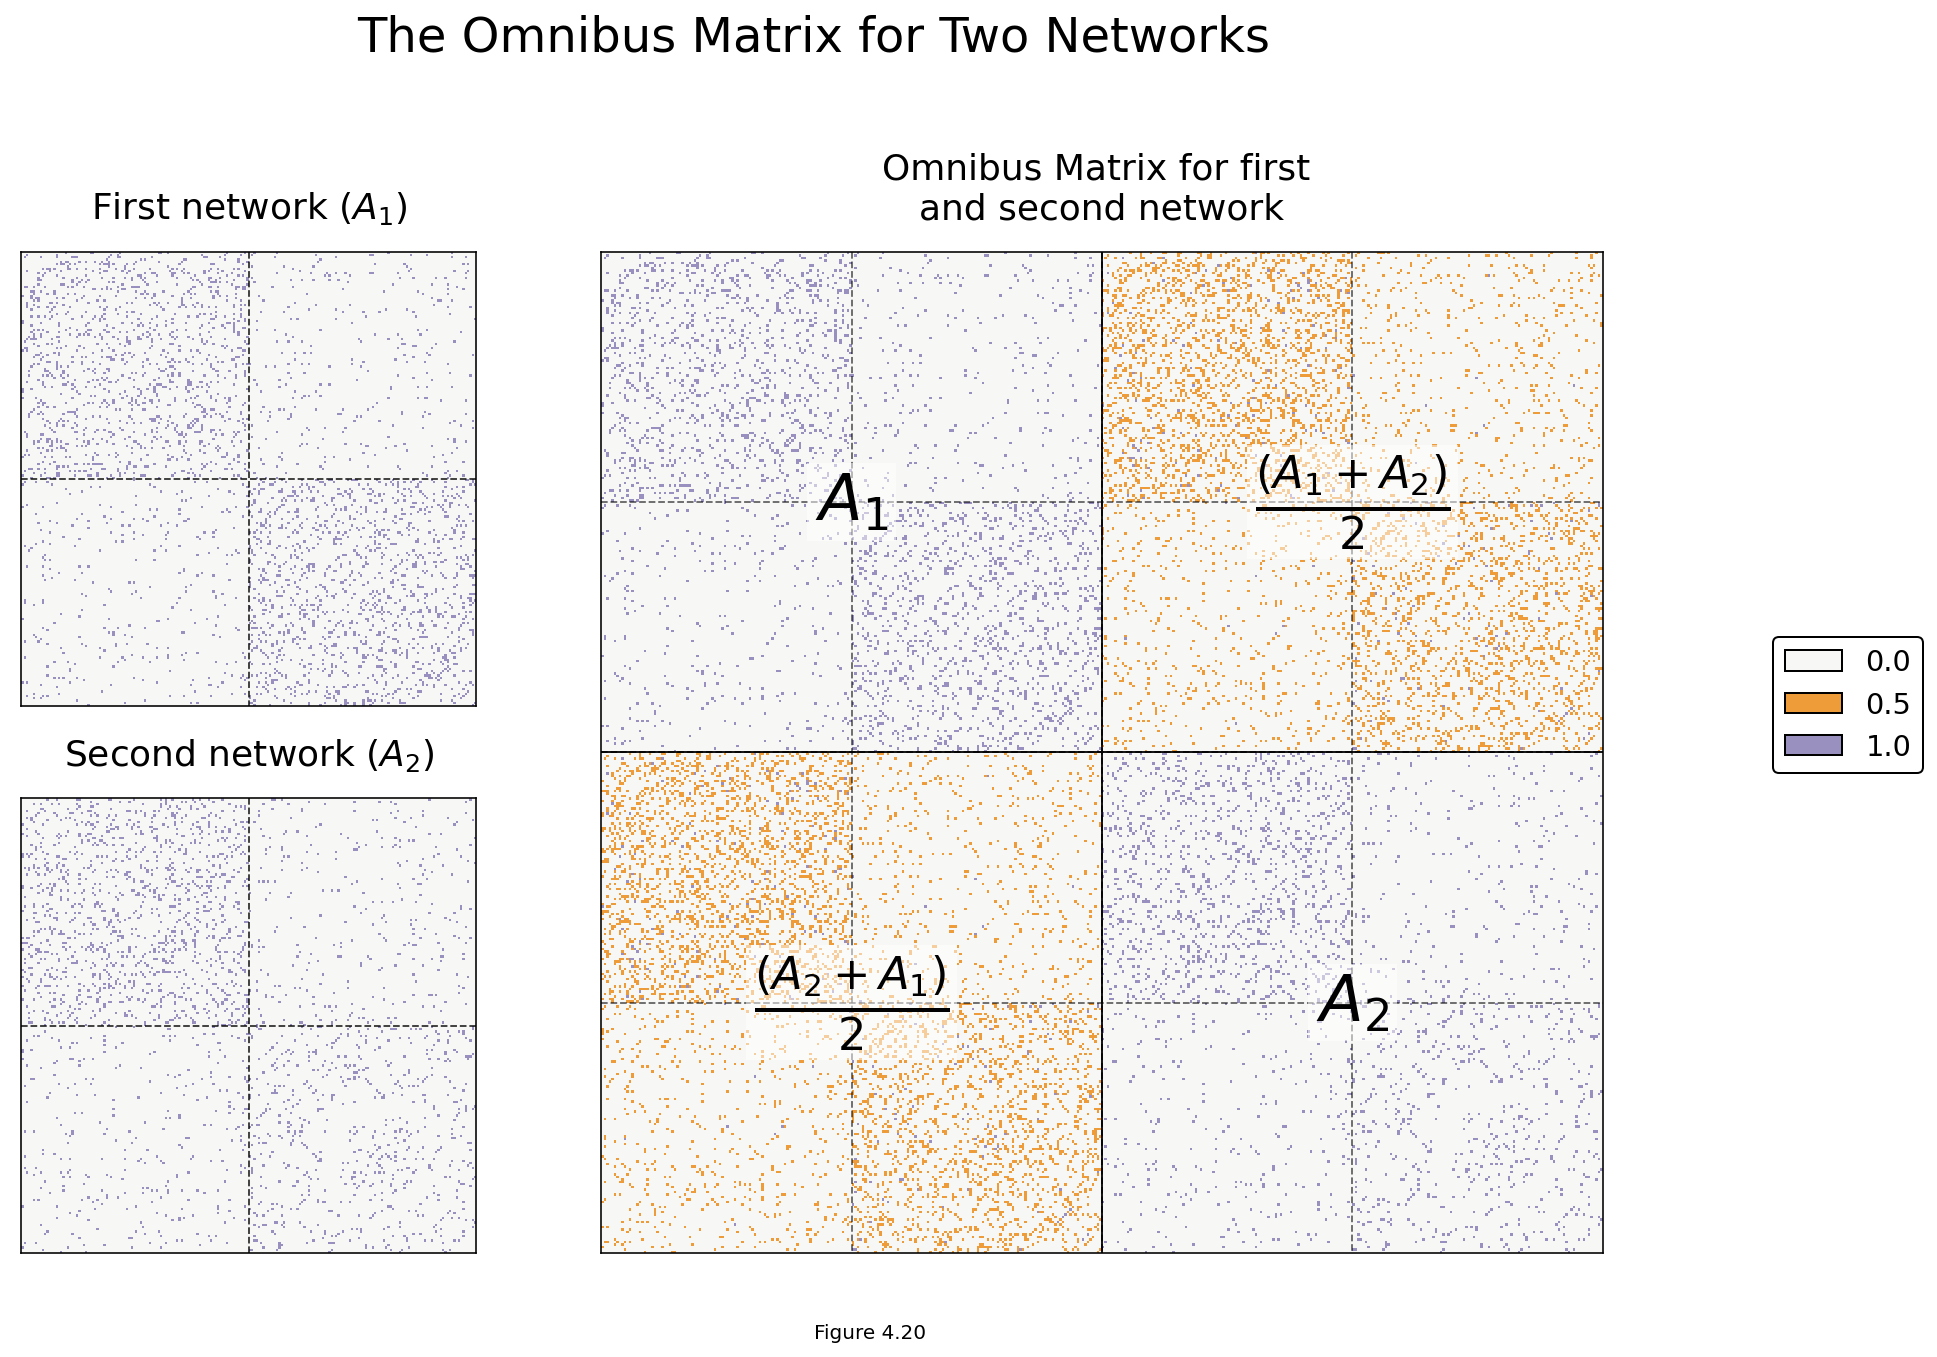

In [38]:
from graphbook_code import text

# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 3)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax_omni = fig.add_subplot(gs[:, 1:])

# first two
omni_cmap = list(np.array(sns.color_palette("PuOr_r", 3))[[1, 2, 0]])
for i, (ax, data) in enumerate(zip([ax0, ax1], [a0, a1])):
    title = r"First network ($A_1$)" if i==0 else r"Second network ($A_2$)"
    hm = lined_heatmap(data, ax=ax, legend=False, title=title, 
                       colors=[omni_cmap[0], omni_cmap[2]])


# big one
hm = lined_heatmap(omni, ax=ax_omni, binary=False, cmap=omni_cmap,
                   title="Omnibus Matrix for first \nand second network",
                   cbar=False, center=None)

# outline
sns.despine(ax=ax_omni, top=False, bottom=False, left=False, right=False)

# separating lines
hm.vlines(len(omni)//2, 0, len(omni), colors="black", lw=.9, alpha=1)
hm.hlines(len(omni)//2, 0, len(omni), colors="black", lw=.9, alpha=1)
for i in [.25, .75]:
    hm.vlines(len(omni)*i, 0, len(omni), colors="black", lw=.9, linestyle="dashed", alpha=.6)
    hm.hlines(len(omni)*i, 0, len(omni), colors="black", lw=.9, linestyle="dashed", alpha=.6)
    
# text
text(r"$A_1$", .25, .75)
text(r"$A_2$", .75, .25)
text(r"$\frac{(A_2 + A_1)}{2}$", .25, .25)
text(r"$\frac{(A_1 + A_2)}{2}$", .75, .75)

# legend
omni_labels = np.unique(omni)
add_legend(legend_labels=omni_labels, colors=omni_cmap)

plt.tight_layout()
fig.suptitle("The Omnibus Matrix for Two Networks", fontsize=24, y=1.1);
plt.figtext(0.5, -.05, "Figure 4.20")

#### Creating the Omnibus Matrix For All Four Networks

Here's the Omnibus Matrix for all four of our networks. You can see adjacency matrices for the original four networks on the diagonal blocks, highlighted in blue, and all possible pairs of averages of adjacency matrices on the off-diagonal blocks, highlighted in orange.

Text(0.5, 0.1, 'Figure 4.21')

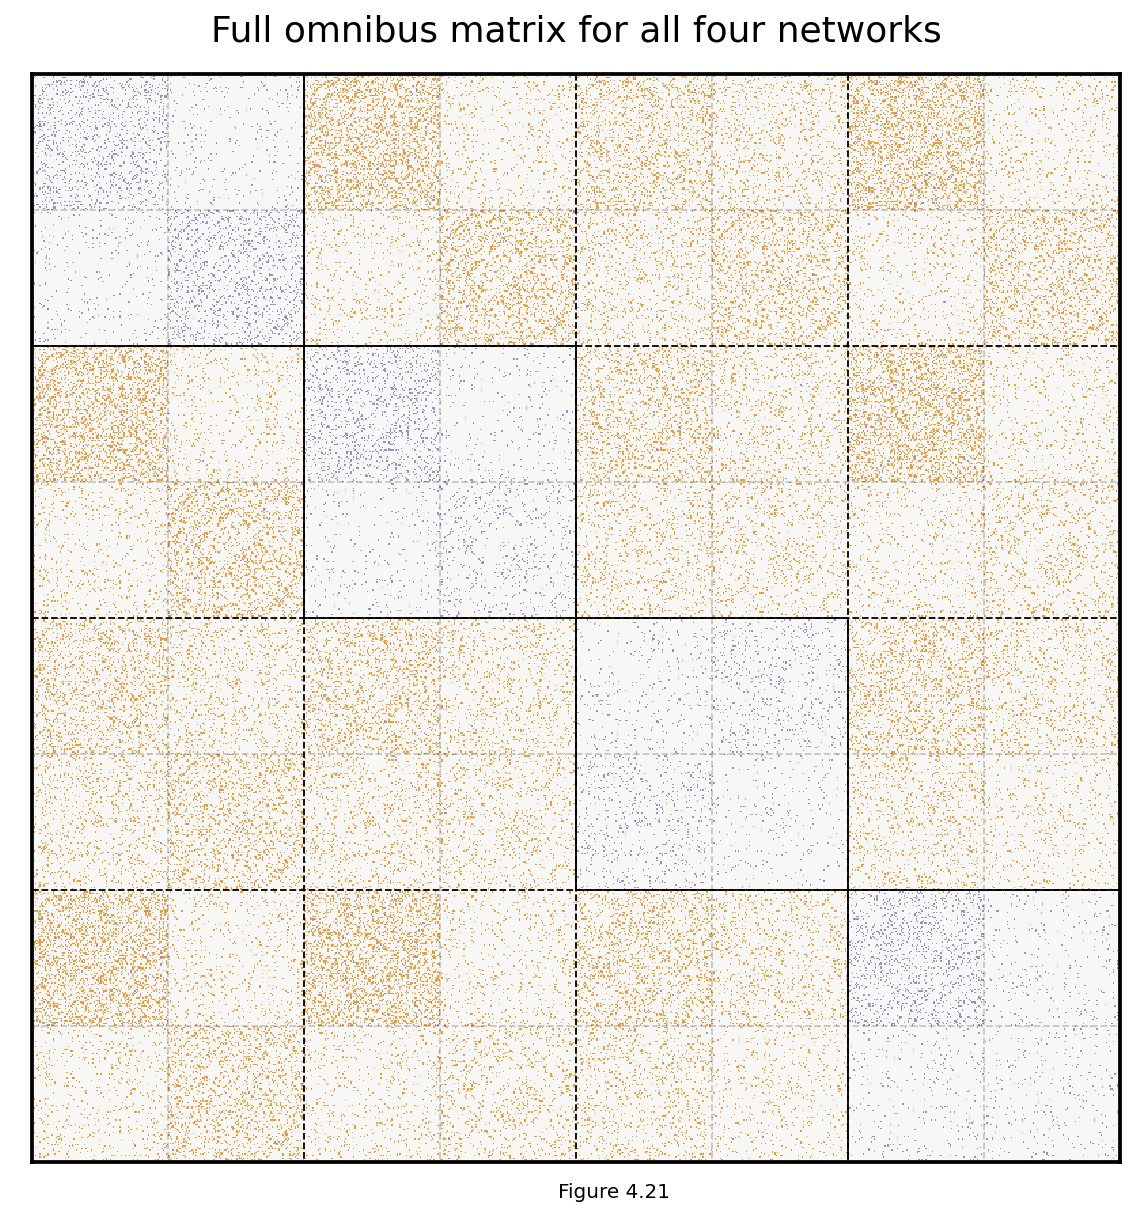

In [39]:
from graspologic.embed.omni import _get_omni_matrix
omni = _get_omni_matrix(networks)

hm = lined_heatmap(omni, binary=False, cmap=omni_cmap, cbar=False,
                   title="Full omnibus matrix for all four networks", center=None, alpha=0)
sns.despine(ax=hm, top=False, bottom=False, left=False, right=False)
for i in np.arange(4)*1/4:
    hm.vlines(len(omni)*i, 0, len(omni), colors="black", lw=.9, linestyle="dashed", alpha=1)
    hm.hlines(len(omni)*i, 0, len(omni), colors="black", lw=.9, linestyle="dashed", alpha=1)
for i in np.arange(1, 8, 2)*1/8:
    hm.vlines(len(omni)*i, 0, len(omni), colors="black", lw=.9, linestyle="dashed", alpha=.2)
    hm.hlines(len(omni)*i, 0, len(omni), colors="black", lw=.9, linestyle="dashed", alpha=.2)

n = len(omni)

# vertical solids
hm.vlines(n//4, 0, n//2, colors="black", lw=.9, alpha=1)
hm.vlines(n//2, n*.25, n*.75, colors="black", lw=.9, alpha=1)
hm.vlines(n*.75, n//2, n, colors="black", lw=.9, alpha=1)

# horizontal solids
hm.hlines(n//4, 0, n//2, colors="black", lw=.9, alpha=1)
hm.hlines(n//2, n*.25, n*.75, colors="black", lw=.9, alpha=1)
hm.hlines(n*.75, n//2, n, colors="black", lw=.9, alpha=1);

plt.figtext(0.5, 0.1, "Figure 4.21")

#### Embedding the Omnibus Matrix

You should understand the next step fairly well by now. We embed the Omnibus Matrix normally, using ASE, as if it were just a normal adjacency matrix. This will create an $nm \times d$ sized latent position matrix (where, remember, $n$ is the number of nodes in each network, $m$ is the number of networks, and $d$ is the number of embedding dimensions). Here, since each of our four networks has 200 nodes, $mn$ is 800, and we chose to embed down to two dimensions.

In [40]:
from graspologic.embed import select_svd

U, D, V = select_svd(omni, n_components=2)
joint_embedding = U @ np.diag(np.sqrt(D))

joint_embedding.shape

(800, 2)

#### Creating Separate Latent Positions In The Same Latent Space

Now, the only question we have remaining is how to actually pull the separate latent positions for each network from this matrix. It turns out that the individual latent positions for each network are actually stacked on top of each other: the first $n$ rows of the joint matrix we just made correspond to the nodes of the first network, the second $n$ rows correspond to the nodes of the second network, and so on. 

If we want, we can pull out the separate latent positions for each network explicitly. Below, we reshape our 2-dimensional $mn \times d$ numpy array for the omnbus embedding into a $m \times n \times d$ array: the embeddings for each network are now simply stacked on top of each other on the third dimension (and the first axis of our numpy array).

In [41]:
m = len(networks)
n = len(networks[0])
latent_networks = joint_embedding.reshape(m, n, -1)

latent_networks.shape

(4, 200, 2)

Below, you can see the embeddings we just created. On the left is the full $mn \times d$ omnibus matrix, and on the right are the slices of the $m \times n \times d$ 3-D array we created above. If you look carefully, you can see that the top two blocks of colors (row-wise) in the larger embedding correspond to the latent positions for network 1, the second two blocks correspond to the latent positions for network 2, and so on. They're a bit squished, so that everything lines up nicely, but they're there.

Text(0.5, 0, 'Figure 4.22')

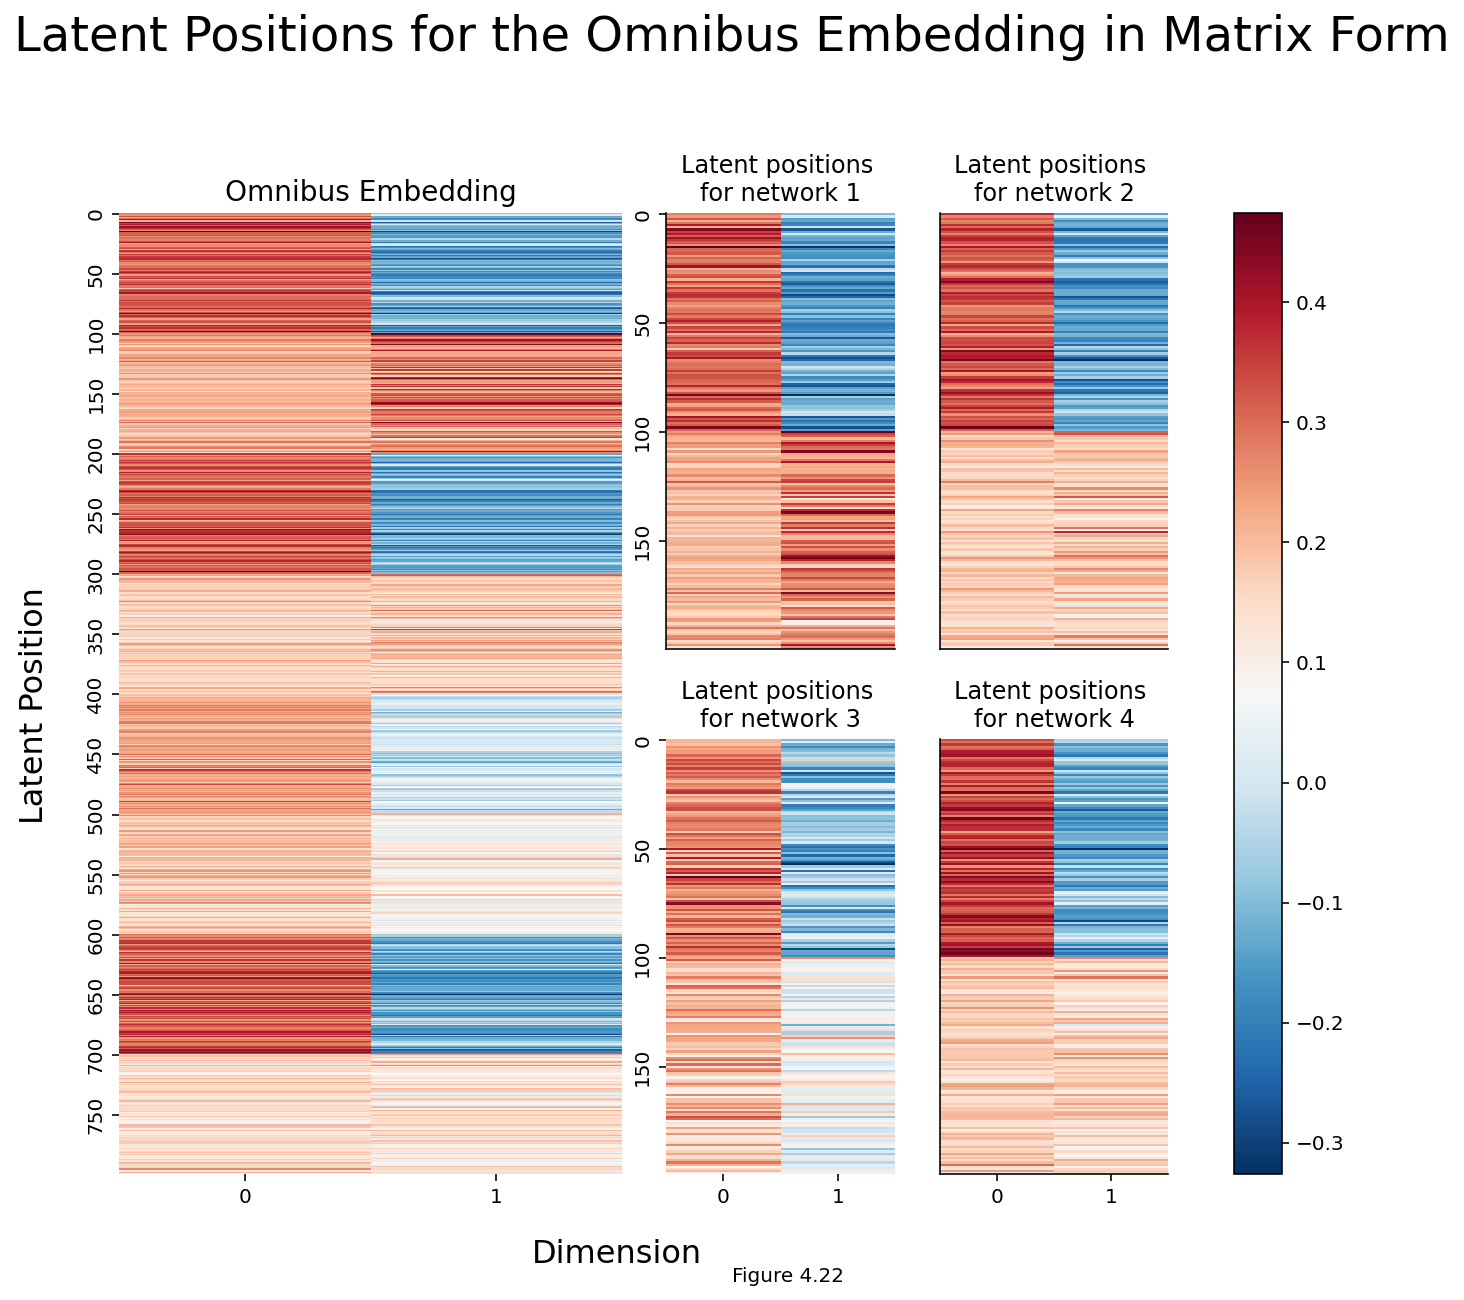

In [42]:
from myst_nb import glue

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 4)

hm_ax = fig.add_subplot(gs[:, :2])
hm = sns.heatmap(joint_embedding, cmap=cmap, ax=hm_ax, yticklabels=50, cbar=False);
hm.set_title("Omnibus Embedding", fontsize=14)
# hm.set(xlabel="Dimension", ylabel="Latent Positions")

ax0 = fig.add_subplot(gs[:2, 2])
ax1 = fig.add_subplot(gs[:2, 3])
ax2 = fig.add_subplot(gs[2:, 2])
ax3 = fig.add_subplot(gs[2:, 3])
for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    plot = sns.heatmap(latent_networks[i], cmap=cmap, ax=ax, 
                       yticklabels=50, cbar=False)
    plot.set_title(f"Latent positions \nfor network {i+1}")
    if ax in {ax0, ax1}:
        rm_ticks(ax, x=False, y=None)
    if ax in {ax1, ax3}:
        rm_ticks(ax, y=False, x=None)


# labels
fig.supxlabel("Dimension", x=.42, fontsize=16)
fig.supylabel("Latent Position", x=.005, fontsize=16)

# colorbar
vmin, vmax = np.array(joint_embedding).min(), np.array(joint_embedding).max()
norm = Normalize(vmin=vmin, vmax=vmax)
im = cm.ScalarMappable(cmap=cmap, norm=norm)

plt.tight_layout()
fig.colorbar(im, ax=np.array([hm_ax, ax0, ax1, ax2, ax3]));

fig.suptitle("Latent Positions for the Omnibus Embedding in Matrix Form", fontsize=24, y=1.1);
plt.figtext(0.5, 0, "Figure 4.22")

And finally, below is the above embeddings, plotted in Euclidean space. Each point is a row of the embedding above, and the dots are colored according to their class label. The big matrix on the left (the joint OMNI embedding) just contains every latent position we have, across all of our networks. This means that, on the lefthand plot, there will be four points for every node (remember that we're operating under the assumption that we have the same set of nodes across all of our networks).

Text(0.5, -0.05, 'Figure 4.23')

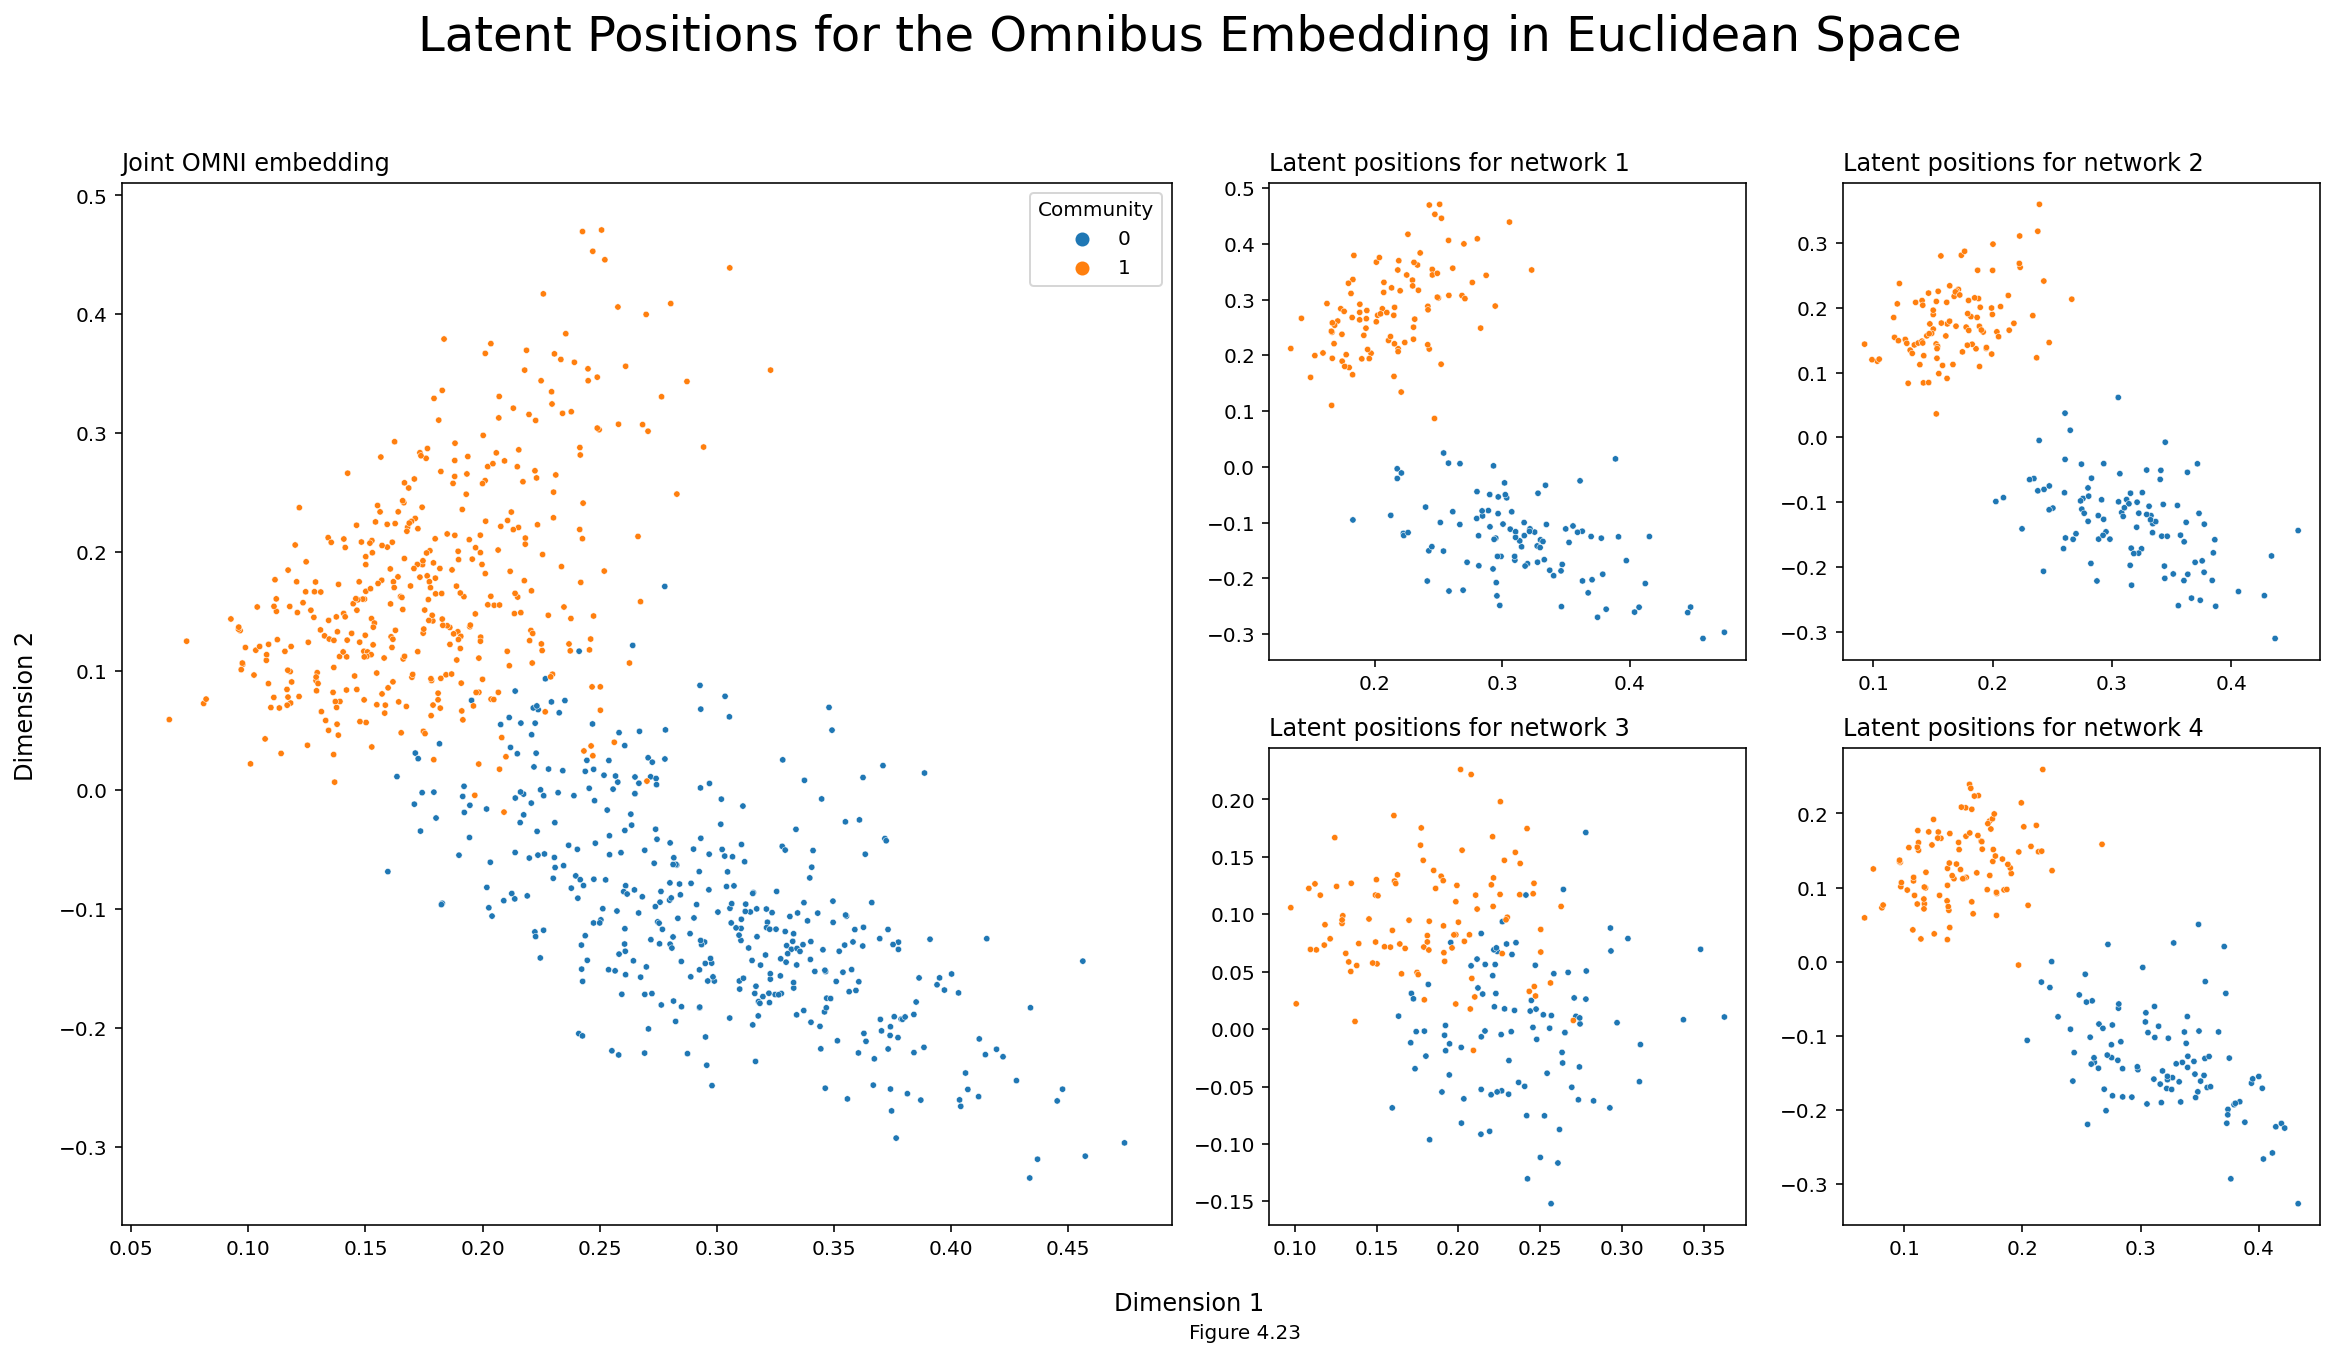

In [43]:
# set up
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
gs = axs[1, 1].get_gridspec()
for ax in axs[:, :2].flat:
    ax.remove()
    
# plot individual networks
for i, ax in enumerate(axs[-2:, -2:].flat):
    plot_latents(latent_networks[i], title=f"Latent positions for network {i+1}", 
                 labels=labels, ax=ax, legend=False)

# average and plot average
joint_ax = fig.add_subplot(gs[:, :2])
plot_latents(joint_embedding, labels=np.tile(labels, 4),
             ax=joint_ax, title="Joint OMNI embedding")

# layout stuff
plt.tight_layout()
fig.supxlabel("Dimension 1", y=-.03)
fig.supylabel("Dimension 2", x=-.01);

fig.suptitle("Latent Positions for the Omnibus Embedding in Euclidean Space", fontsize=24, y=1.1);
plt.figtext(0.5, -.05, "Figure 4.23")

## How Can You Use The Omnibus Embedding?

Fundamentally, the omnibus embedding is useful is because it lets you avoid the somewhat annoying and noise-generating process of figuring out a good way to rotate your separate embeddings to line them up. For instance, say you want to figure out if two networks are generated from the same distribution (This means that the matrix that contains edge probabilities, $\textbf{P}$, is the same for both networks). Then, it's reasonable to assume that their latent positions will be pretty close to each other. Look at the equation below:

$\min_{W} ||{\hat{N_1} - \hat{N_2}W}||_F$

Here:
- $W$ is a matrix that just rotates or flips (called an isometry, or an orthonormal matrix)
- $\hat{N_1}$ and $\hat{N_2}$ are the estimated latent positions for networks one and two, respectively

the $||X||_F$ syntax means that we're taking the frobenius norm of $X$. Taking the frobenius norm of a matrix is the same as unwrapping the matrix into a giant vector and measuring that vector's length. So, this equation is saying that the latent position for a given node in network one should be close to the latent position in network two.

But, there's that $W$ there, the rotation matrix. We actually wish we didn't have to find it. We have to because of the same problem we keep running into: you can rotate latent positions and they'll still have the same dot product relative to each other, and so you can only embed a network up to a rotation. In practice, you can find this matrix and rotate latent positions for separate networks using it to compare them directly, but again, it's annoying, adds compute power that you probably don't want to use, and it'll add noise to any kind of inference you want to do later.

The Omnibus Embedding is fundamentally a solution to this problem. Because the embeddings for all of your networks live in the same space, you don't have to rotate them manually -- and you cut out the noise that gets created when you have to *infer* a good rotation matrix. We'll explore all the downstream use cases in future chapters, but below is a sneak peak. 

The figure below (adapted from Gopalakrishnan et al. 2021 {cite}`mcc`,  is the omnibus embedding for 32 networks created from a bunch of mouse brains, some of which have been genetically modified. The nodes of these networks represent the regions of a mouse brain and the edges represent how well-connected the neurons in a given pair of regions are. The figure below actually only shows two nodes: the node representing one region in the left hemisphere, and the node representing its corresponding region in the right hemisphere.

So what we're actually *plotting* in this embedding is a bit different than normal, because rather than being nodes, the points we plot are *networks*: one for each of our thirty-two mice. The only reason we're able to get away with doing this is the omnibus embedding: each network lives in the same space!

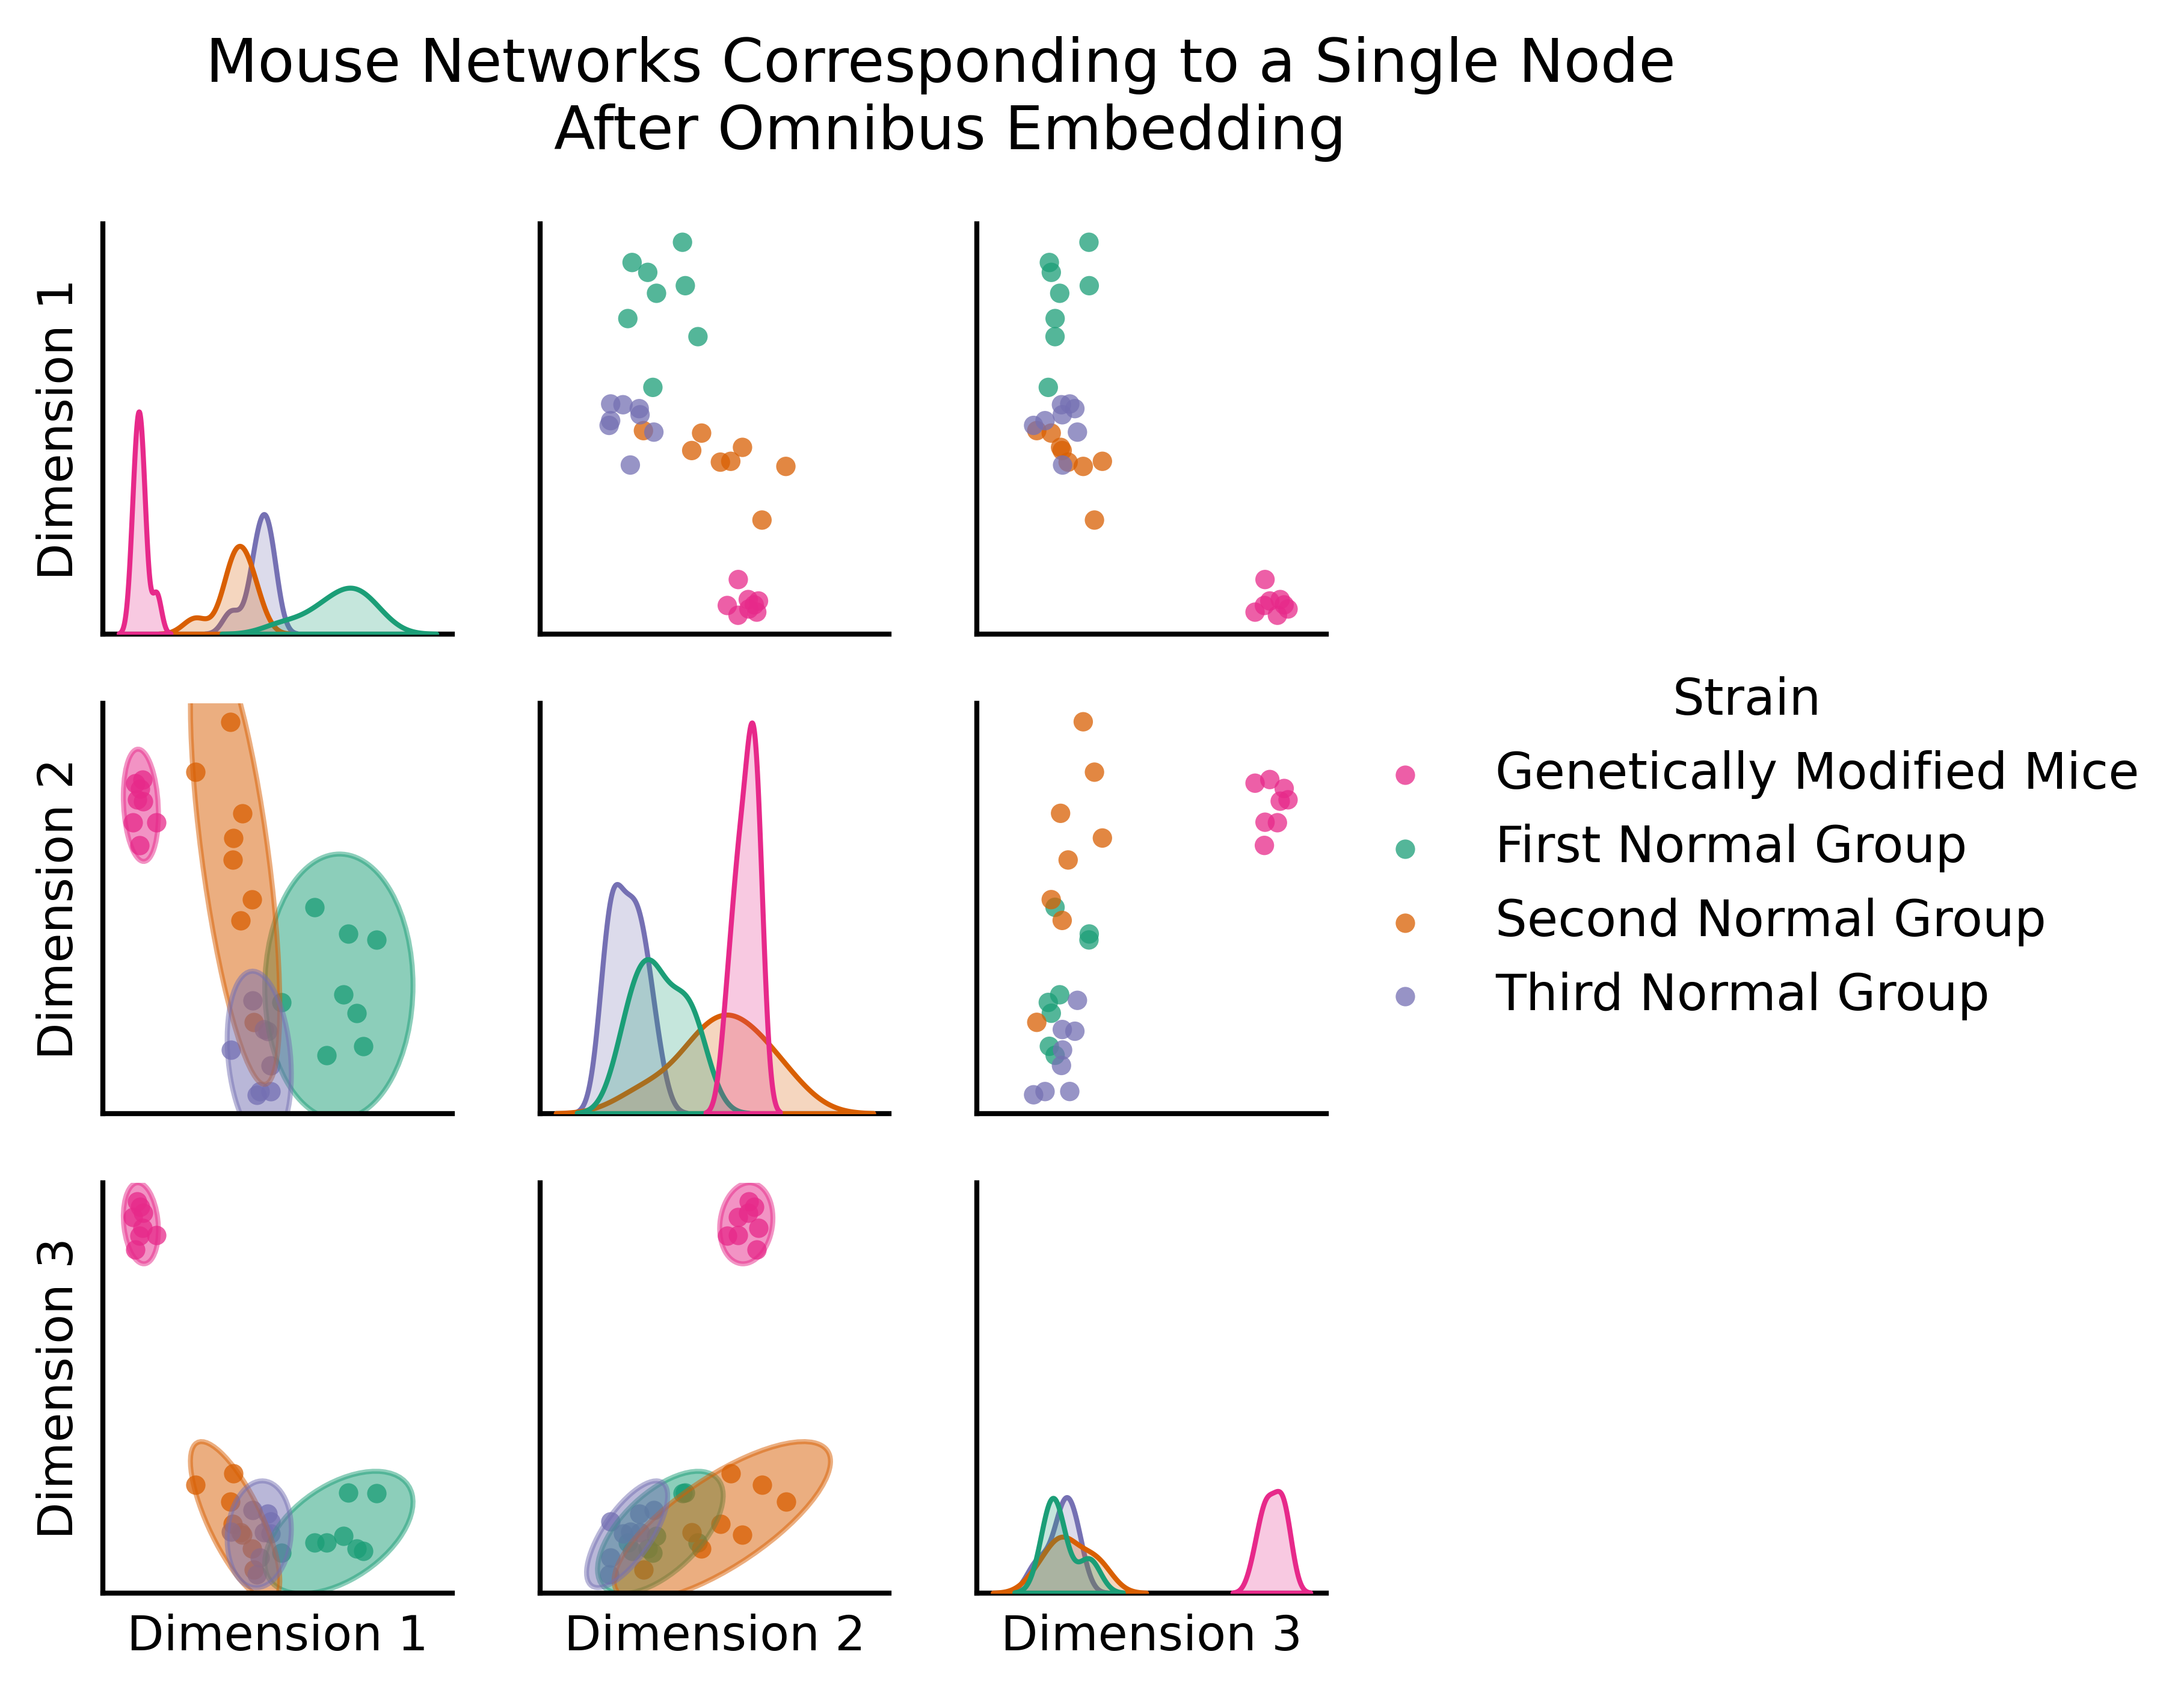

Text(0.5, -0.05, 'Figure 4.24')

<Figure size 432x288 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from graspologic.embed import OmnibusEmbed
from graspologic.datasets import load_mice

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.stats.distributions import chi2


def _get_parameters(x, y):
    mu = np.array([x.mean(), y.mean()])
    cov = np.cov(x, y)
    return mu, cov


def _get_eigen(cov):
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    return eigvals, eigvecs


def _get_ellipse_parameters(cov, ci):

    eigvals, eigvecs = _get_eigen(cov)

    # Calculate angle of displacement from x-axis
    theta = np.arctan2(*eigvecs[:, 0][::-1])
    theta = np.degrees(theta)

    # Calculate scaling factor based on probability
    dof = len(eigvals)
    alpha = 1 - (1 - ci) / 2
    scale = chi2.ppf(alpha, dof)
    width, height = 2 * np.sqrt(scale * eigvals)

    return width, height, theta


def make_ellipse(x, y, ci, **kwargs):
    mu, cov = _get_parameters(x, y)
    width, height, theta = _get_ellipse_parameters(cov, ci)
    ellipse = Ellipse(mu, width, height, theta, alpha=0.5, **kwargs)
    return ellipse


def draw_probability_ellipse(x, y, ci, **kwargs):
    ellipse = make_ellipse(x, y, ci, **kwargs)
    ax = plt.gca()
    ax.add_artist(ellipse)

    plot_kws = dict(alpha=0.75, s=15, linewidth=0, marker="o")
    ax.scatter(x, y, **plot_kws, **kwargs)


def munge_embedding(embedding, labels):
    col_names = [f"Dimension {i}" for i in range(1, embedding.shape[1] + 1)]
    df = pd.DataFrame(embedding, columns=col_names)
    df["Strain"] = labels
    return df


def _pairgrid(embedding, labels):
    df = munge_embedding(embedding, labels)

    palette = ["#e7298a", "#1b9e77", "#d95f02", "#7570b3"]
    plot_kws = dict(alpha=0.75, s=15, linewidth=0, marker="o")

    with sns.plotting_context("paper", font_scale=1):
        g = sns.PairGrid(df, hue="Strain", palette=palette, height=1.5)
        g = g.map_upper(sns.scatterplot, **plot_kws)
        g = g.map_diag(sns.kdeplot, lw=1, shade=True)
        g.set(xticks=[], yticks=[])

    return g


def ellipse_pairgrid(embedding, labels, ci, **kwargs):
    g = _pairgrid(embedding, labels)
    kwargs["ci"] = ci
    g = g.map_lower(draw_probability_ellipse, **kwargs)
    return g

# Load the full mouse dataset
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)

# Sort the connectomes and genotypic labels so BTBR is first
label_indices = np.argsort(mice.labels).reshape(4, 8)
label_indices = label_indices[[1, 0, 2, 3]].reshape(-1)

labels = mice.labels[label_indices]
mapping = dict(BTBR="Genetically Modified Mice", B6="First Normal Group", 
               CAST="Second Normal Group", DBA2="Third Normal Group")
labels = [mapping[old] for old in labels]
graphs = graphs[label_indices]

# Jointly embed graphs using omnibus embedding
embedder = OmnibusEmbed()
omni_embedding = embedder.fit_transform(graphs)


# Get index for the input structure
index = mice.atlas.query(f"Structure == 'Corpus_Callosum'")["ROI"].values[0]
index -= 1

# Make the plot
g = ellipse_pairgrid(omni_embedding[:, index, :3], labels, ci=0.9)
g.fig.suptitle("Mouse Networks Corresponding to a Single Node \nAfter Omnibus Embedding", y=1.08)
g.fig.set(dpi=300)
g.add_legend()
plt.show()
g.add_legend(title="Type of Mouse");
sns.move_legend(g, "center right", frameon=True)
plt.figtext(0.5, -.05, "Figure 4.24")

You can clearly see a difference between the genetically modified mice and the normal mice. The genetically modified mice are off in their own cluster; if you're familiar with classical statistics, you could do a MANOVA here and find that the genetically modified mice are significantly different from the rest - if we wanted to, we could figure out which mice are genetically modified, even without having that information in advance!